## Table of Contents
<br>
<ol> 
    <li style="font-weight: bold;">
    <h2><a href='#1' style="text-decoration : none; color: #000000;">Vulnerable/Control Set 30:70 </a></h2>
    <ul> <a href='#1.1' style="text-decoration : none; color: #000000;"> 1.1 Loading Data </a></ul>
    <ul> <a href='#1.2' style="text-decoration : none; color: #000000;"> 1.2  70: 30 Train Test split </a>
    <ol> <a href='#1.2.1' style="text-decoration : none; color: #000000;">1.2.1 Results </a></ol></ul>
    <ul> <a href='#1.3' style="text-decoration : none; color: #000000;"> 1.3  80: 20 Train Test split </a>
    <ol> <a href='#1.3.1' style="text-decoration : none; color: #000000;">1.3.1 Results </a></ol></ul></li>
</ol>
<ol start ='2'>
    <li style="font-weight: bold;">
    <h2><a href='#2' style="text-decoration : none; color: #000000;">Vulnerable/Control Set 50:50 </a></h2>
    <ul> <a href='#2.1' style="text-decoration : none; color: #000000;"> 2.1 Loading Data </a></ul>
    <ul> <a href='#2.2' style="text-decoration : none; color: #000000;"> 2.2  70: 30 Train Test split </a>
    <ol> <a href='#2.2.1' style="text-decoration : none; color: #000000;">2.2.1 Results </a></ol></ul>
    <ul> <a href='#2.3' style="text-decoration : none; color: #000000;"> 2.3  80: 20 Train Test split </a>
    <ol> <a href='#2.3.1' style="text-decoration : none; color: #000000;">2.3.1 Results </a></ol></ul></li>
</ol>

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix as CM,accuracy_score,auc,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize
from pandas_ml import ConfusionMatrix

from IPython.display import display,clear_output,HTML

### <a id='1' style="text-decoration : none; color: #000000;"> 1 Vulnerable/Control 30:70 </a>

#### <a id='1.1' style="text-decoration : none; color: #000000;"> 1.1 Loading Data </a>

In [191]:
df=pd.read_csv('Final_feature_set-Copy1.csv',index_col=['Unnamed: 0'])
df.fillna(value=0,inplace=True)

print("Count of Malicious/Non-Malicious users:")
display(df.Malicious.value_counts())

print("\nNumber of Users with Age less than equal to 0:")
display(df[df.Age<=0]['Malicious'].value_counts())

print("After eliminating users whose predicted age is less than 0 and randomly selecting from control set users:")
df=df[df.Age>0]
nm=df[df.Malicious==0]
m=df[df.Malicious==1]

df=m.append(nm.sample(frac=((len(m)/0.3)*0.7)/len(nm),random_state=10))

df.Malicious.value_counts()

Count of Malicious/Non-Malicious users:


0    7059
1    1905
Name: Malicious, dtype: int64


Number of Users with Age less than equal to 0:


0    3
1    2
Name: Malicious, dtype: int64

After eliminating users whose predicted age is less than 0 and randomly selecting from control set users:


0    4440
1    1903
Name: Malicious, dtype: int64

In [192]:
df2=df.copy(deep=True)
df2.drop(['User_Id','User_Name_x','Created_At','Language'],axis=1,inplace=True)
df2.set_index(['User_Screen_Name'],inplace=True,drop=True)
df2.Gender=df2.Gender.apply(lambda x: 1 if x=='F' else 0)
df2.drop(['Statuses_Count','User_Name_y'],axis=1,inplace=True)
df2.head()

,Followers_Count,Friends_Count,Listed_Count,Favorites_Count,Number of Tweets,Avg Number of Mentions,Average Number of Links,Average Number of Words,Acc_Age_Month,Malicious,Age,Gender
User_Screen_Name,,,,,,,,,,,,
RedstripeC,90,110,2,3325,1093,1.690759,0.560842,14.605672,11.456814,1,25.098068,0
jenni_cf,7,133,0,12,12,1.166667,0.666667,18.083333,87.070705,1,39.404307,0
rpatey,883,702,28,625,2673,0.784138,0.246539,13.228582,108.383367,1,32.349005,1
Emperorkelveen,473,213,1,8,2361,1.022025,0.137654,9.180856,93.539661,1,28.791329,0
springyjay,62,172,2,4220,901,0.759156,0.054384,12.328524,63.190325,1,22.298607,1


In [4]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

#### <a id='1.2' style="text-decoration : none; color: #000000;"> 1.2  70: 30 Train Test split </a>

In [5]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [6]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 1.2.1 KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,20,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3108     0     3108
True           0  1332     1332
__all__     3108  1332     4440

Accuracy of the  KNN  model for test data is: 0.8039936941671045

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1289    43     1332
True         330   241      571
__all__     1619   284     1903

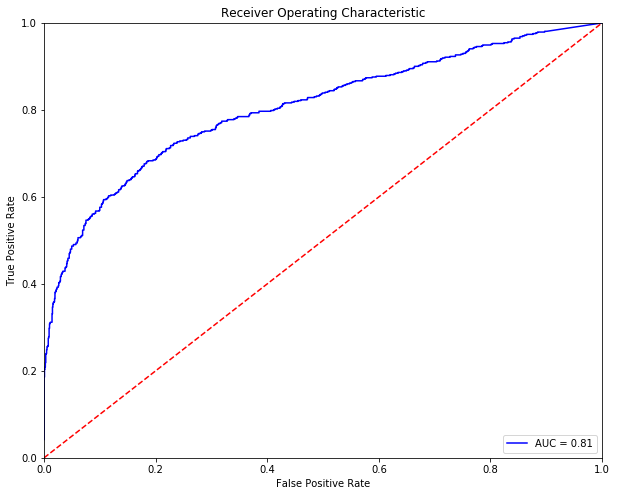

Optimal Threshold is 0.23710629151922524
Accuracy on test data is: 0.7377824487651077


Predicted  False  True  __all__
Actual                         
False        983   349     1332
True         150   421      571
__all__     1133   770     1903

In [8]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [9]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.2 Logistic

In [10]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.7,False,True,0.7,10000,ovr,l2,sag,0.1


Accuracy of the  Logistic  model for the training data is: 0.7871621621621622

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2895   213     3108
True         732   600     1332
__all__     3627   813     4440

Accuracy of the  Logistic  model for test data is: 0.7735155018392013

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1240    92     1332
True         339   232      571
__all__     1579   324     1903

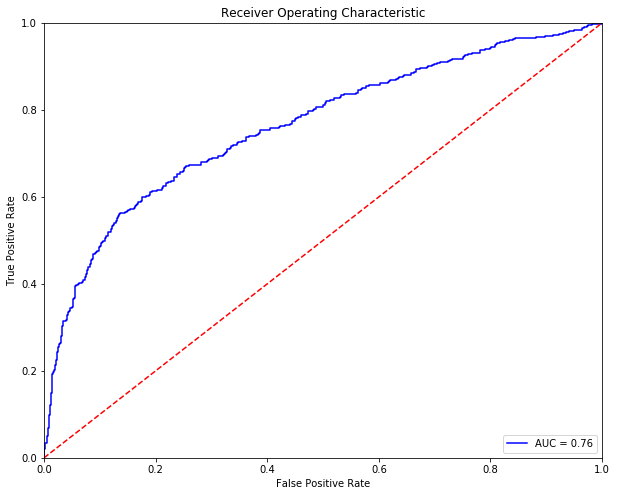

Optimal Threshold is 0.27454328149258006
Accuracy on test data is: 0.6899632159747767


Predicted  False  True  __all__
Actual                         
False        919   413     1332
True         177   394      571
__all__     1096   807     1903

In [11]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [12]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.3 Random Forest Classifier

In [13]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          3108  0     3108
1          1332  0     1332
__all__    4440  0     4440

Accuracy of the  Random Forest Trees  model for test data is: 0.6999474513925381

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          1332  0     1332
1           571  0      571
__all__    1903  0     1903

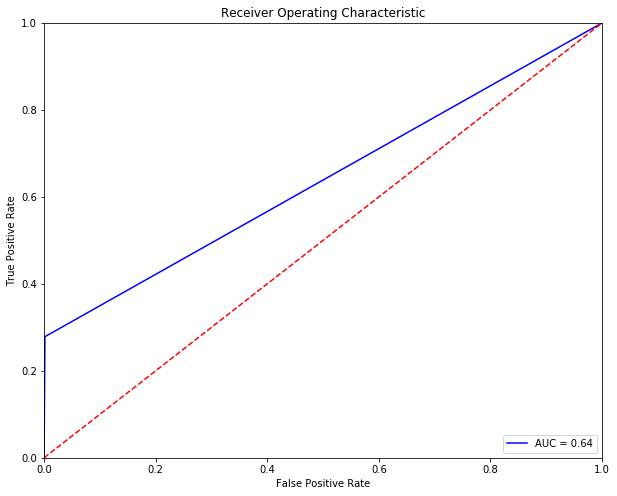

Optimal Threshold is 0.30657385448362273
Accuracy on test data is: 0.6999474513925381


Predicted   0.0  1.0  __all__
Actual                       
0.0        1332    0     1332
1.0         571    0      571
__all__    1903    0     1903

In [14]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [15]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

3108
0
0
3108
1332
0
0
1332
1.0
0.0
0.0
1.0
1332
0
0
1332
571
0
0
571
1.0
0.0
0.0
1.0
1332
0
0
1332
571
0
0
571
1.0
0.0
0.0
1.0


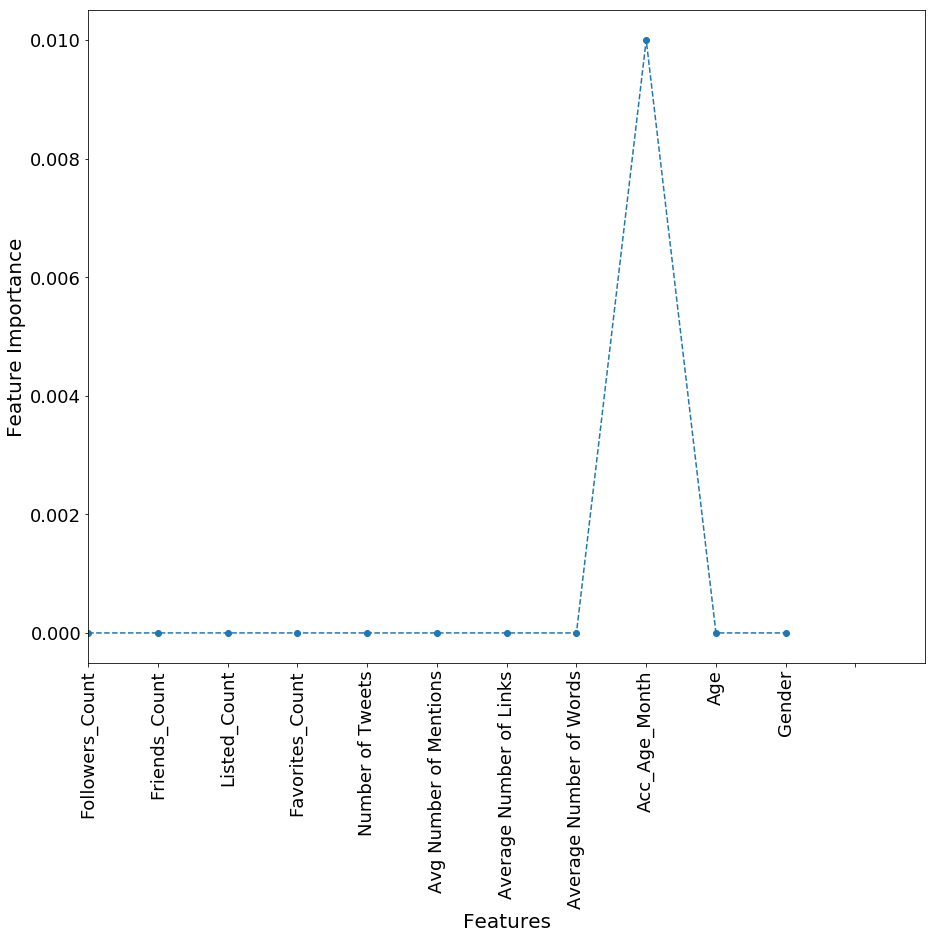

In [16]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [17]:
pd.Series(rf.feature_importances_,index=columns)

Followers_Count            0.00
Friends_Count              0.00
Listed_Count               0.00
Favorites_Count            0.00
Number of Tweets           0.00
Avg Number of Mentions     0.00
Average Number of Links    0.00
Average Number of Words    0.00
Acc_Age_Month              0.01
Age                        0.00
Gender                     0.00
dtype: float64

##### 1.2.4 AdaBoost Classifier

In [18]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.843018018018018

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2975   133     3108
True         564   768     1332
__all__     3539   901     4440

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8339464004203888

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1267    65     1332
True         251   320      571
__all__     1518   385     1903

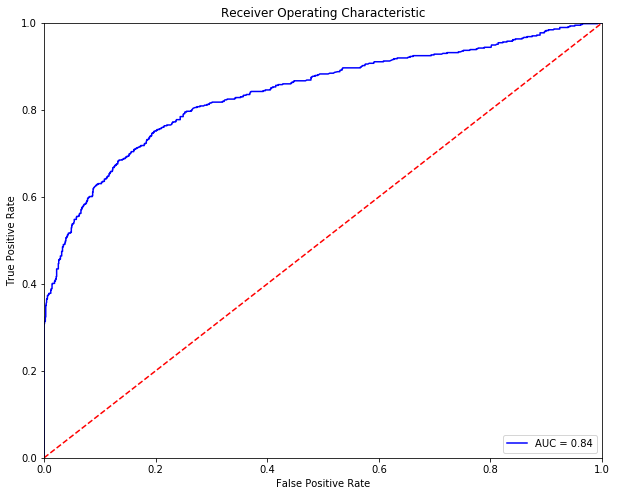

Optimal Threshold is 0.49354468754519604
Accuracy on test data is: 0.7703625853914872


Predicted  False  True  __all__
Actual                         
False       1027   305     1332
True         132   439      571
__all__     1159   744     1903

In [19]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [20]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

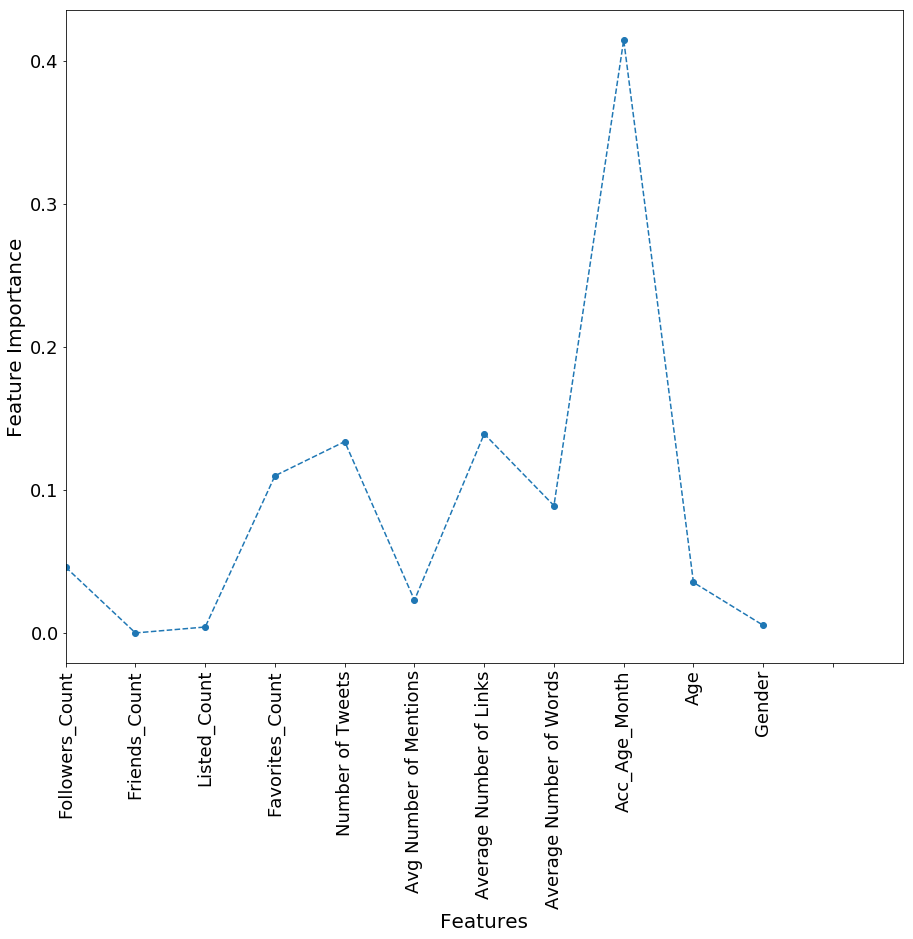

In [21]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [22]:
pd.Series(ada.feature_importances_,index=columns)

Followers_Count            0.045963
Friends_Count              0.000000
Listed_Count               0.004136
Favorites_Count            0.109858
Number of Tweets           0.133768
Avg Number of Mentions     0.022906
Average Number of Links    0.139144
Average Number of Words    0.088993
Acc_Age_Month              0.414576
Age                        0.035330
Gender                     0.005325
dtype: float64

##### 1.2.5 GradientBoosting Classifier

In [23]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,15,0.1,150,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.868018018018018

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3001   107     3108
True         479   853     1332
__all__     3480   960     4440

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8418286915396742

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1268    64     1332
True         237   334      571
__all__     1505   398     1903

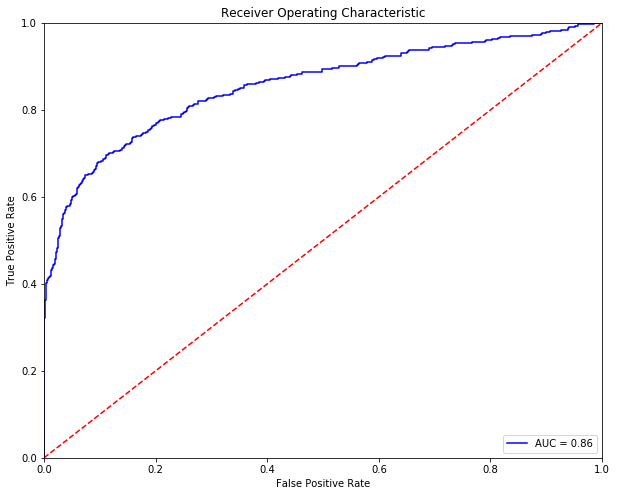

Optimal Threshold is 0.22254042976016367
Accuracy on test data is: 0.7782448765107725


Predicted  False  True  __all__
Actual                         
False       1036   296     1332
True         126   445      571
__all__     1162   741     1903

In [24]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [25]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

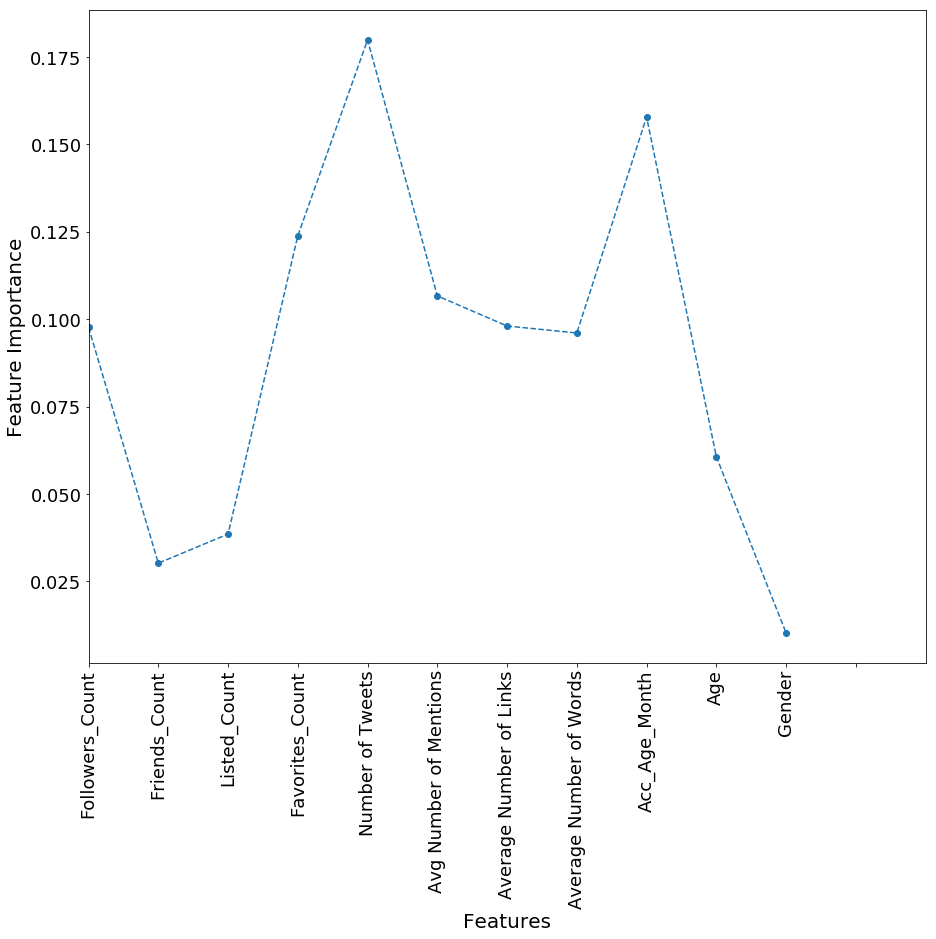

In [26]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [27]:
pd.Series(gbc.feature_importances_,index=columns)

Followers_Count            0.097692
Friends_Count              0.030233
Listed_Count               0.038566
Favorites_Count            0.123898
Number of Tweets           0.179917
Avg Number of Mentions     0.106700
Average Number of Links    0.098079
Average Number of Words    0.096075
Acc_Age_Month              0.157871
Age                        0.060694
Gender                     0.010275
dtype: float64

##### 1.2.6 ExtraTree Classifier

In [28]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,entropy,20,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8538288288288288

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2906   202     3108
True         447   885     1332
__all__     3353  1087     4440

Accuracy of the  Extra Decision Tree  model for test data is: 0.8102995270625328

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1209   123     1332
True         238   333      571
__all__     1447   456     1903

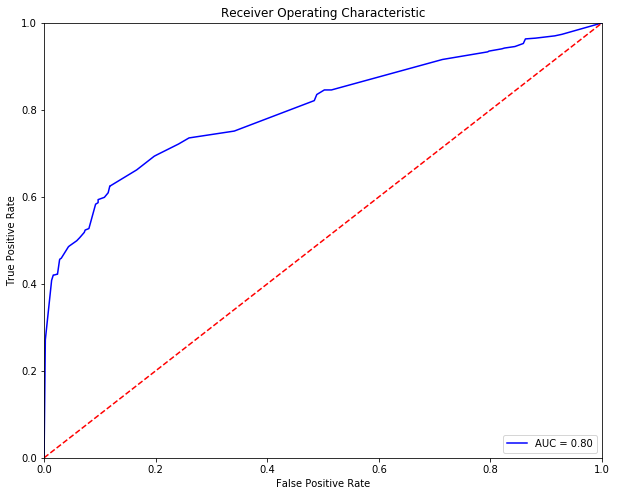

Optimal Threshold is 0.16
Accuracy on test data is: 0.7477666841828692


Predicted  False  True  __all__
Actual                         
False       1011   321     1332
True         159   412      571
__all__     1170   733     1903

In [29]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [30]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

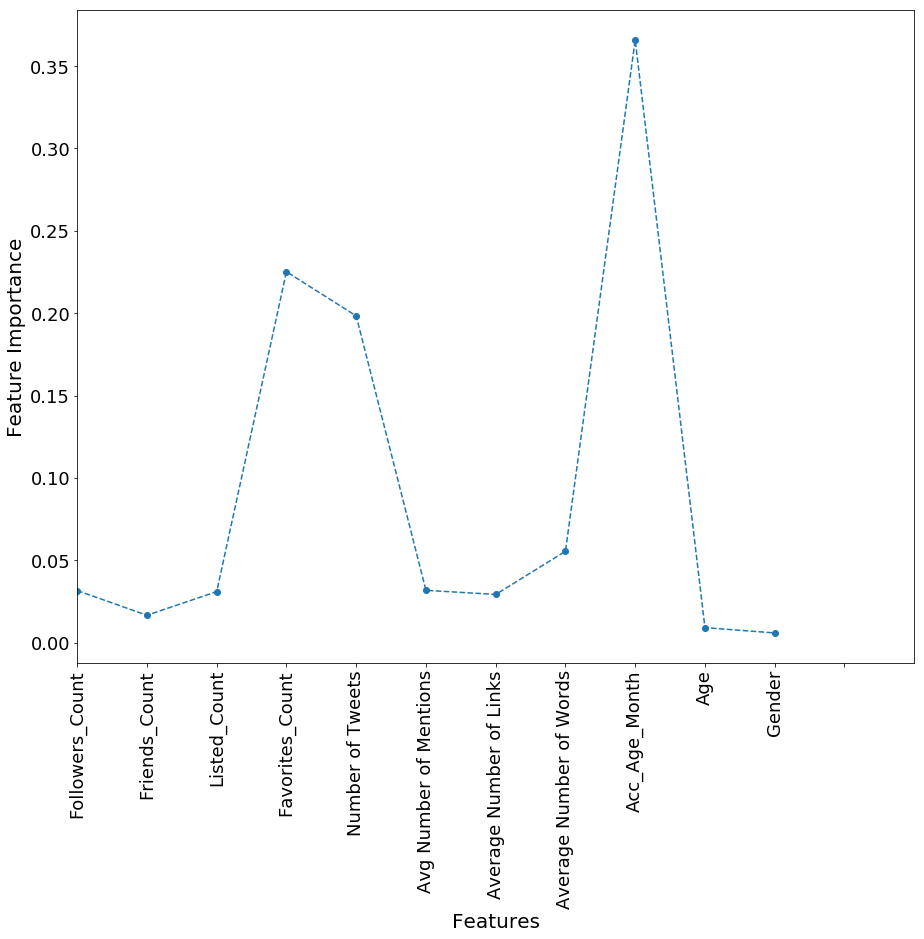

In [31]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [32]:
pd.Series(ext.feature_importances_,index=columns)

Followers_Count            0.031598
Friends_Count              0.016615
Listed_Count               0.030958
Favorites_Count            0.225183
Number of Tweets           0.198344
Avg Number of Mentions     0.031760
Average Number of Links    0.029234
Average Number of Words    0.055435
Acc_Age_Month              0.365890
Age                        0.009093
Gender                     0.005889
dtype: float64

##### 1.2.7 Bagging Classifier

In [33]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.3,500,True,0


Accuracy of the  Bagging  model for the training data is: 0.9114864864864864

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3105     3     3108
True         390   942     1332
__all__     3495   945     4440

Accuracy of the  Bagging  model for test data is: 0.8281660535995796

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1305    27     1332
True         300   271      571
__all__     1605   298     1903

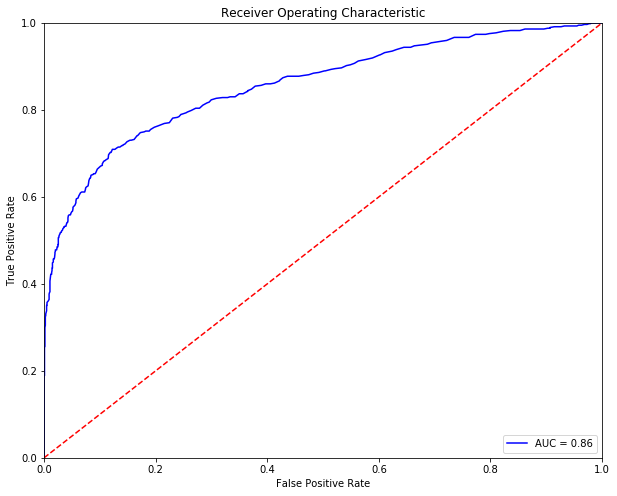

Optimal Threshold is 0.288
Accuracy on test data is: 0.7798213347346296


Predicted  False  True  __all__
Actual                         
False       1045   287     1332
True         132   439      571
__all__     1177   726     1903

In [34]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [35]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.8 Voting Classifier

In [36]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9306306306306307


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       3103     5     3108
True         303  1029     1332
__all__     3406  1034     4440

The test accuracy is: 0.8239621650026274


Predicted  False  True  __all__
Actual                         
False       1277    55     1332
True         280   291      571
__all__     1557   346     1903

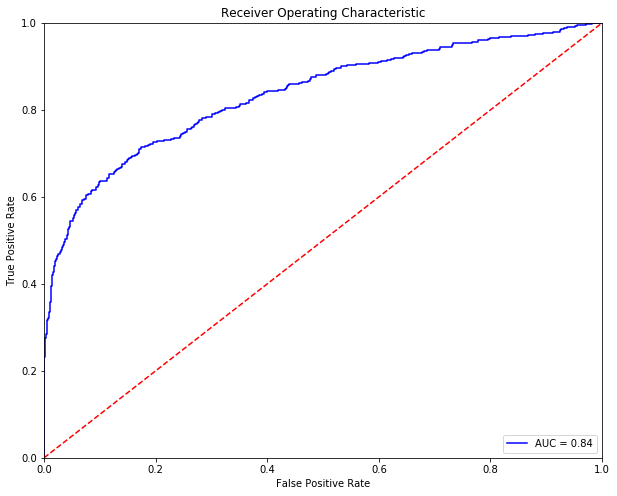

Optimal Threshold is 0.2999954593893887
Accuracy on test data is: 0.7472411981082502


Predicted  False  True  __all__
Actual                         
False        996   336     1332
True         145   426      571
__all__     1141   762     1903

In [37]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [38]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.9 Deep Learning

In [40]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.881756756649361


Predicted  False  True  __all__
Actual                         
False       2992   116     3108
True         409   923     1332
__all__     3401  1039     4440

The accuracy of the model on test data is: 0.815554387808723


Predicted  False  True  __all__
Actual                         
False       1216   116     1332
True         235   336      571
__all__     1451   452     1903

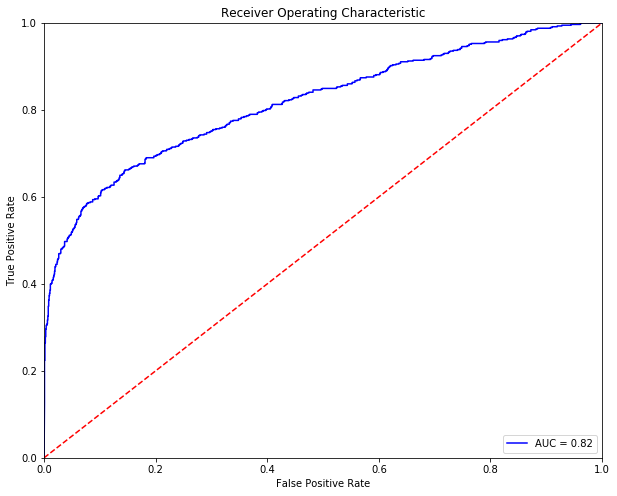

Optimal Threshold is 0.22893858
Accuracy of Logistic Model on training data is: 0.7341040462427746


Predicted  False  True  __all__
Actual                         
False        978   354     1332
True         152   419      571
__all__     1130   773     1903

In [41]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [42]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.10 Deep Learning with Grid Search

In [44]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   48.0s finished


The accuracy of the model on training data is: 0.8114864864864865


Predicted  False  True  __all__
Actual                         
False       2886   222     3108
True         615   717     1332
__all__     3501   939     4440

The accuracy of the model on test data is: 0.7877036258539148


Predicted  False  True  __all__
Actual                         
False       1210   122     1332
True         282   289      571
__all__     1492   411     1903

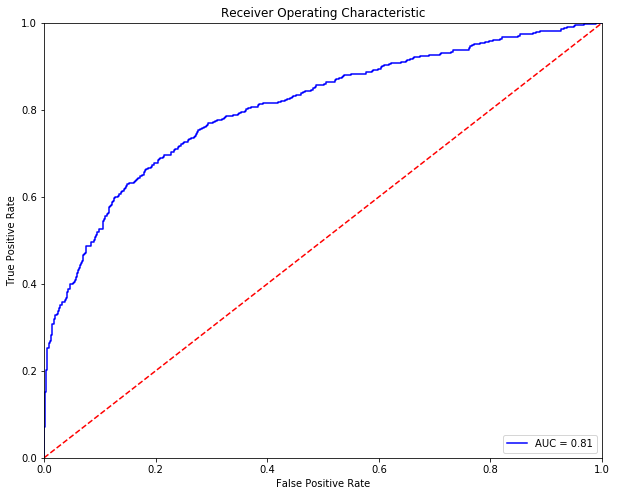

Optimal Threshold is 0.2622011
Accuracy on test data is: 0.7362059905412507


Predicted  False  True  __all__
Actual                         
False        982   350     1332
True         152   419      571
__all__     1134   769     1903

In [45]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [46]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id='#1.2.1' style="text-decoration : none; color: #000000;">1.2.1 Results </a>

In [47]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1332.0,3108.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.787162,600.0,2895.0,213.0,732.0,0.068533,0.549550
RandomForestClassifier,0.700000,2175.6,932.4,932.4,399.6,0.700000,0.300000
AdaBoostClassifier,0.843018,768.0,2975.0,133.0,564.0,0.042793,0.423423
GradientBoostingClassifier,0.868018,853.0,3001.0,107.0,479.0,0.034427,0.359610
ExtraTreeClassifier,0.853829,885.0,2906.0,202.0,447.0,0.064994,0.335586
BaggingClassifier,0.911486,942.0,3105.0,3.0,390.0,0.000965,0.292793
VotingClassifier,0.930631,1029.0,3103.0,5.0,303.0,0.001609,0.227477
Neural Network-1,0.881757,923.0,2992.0,116.0,409.0,0.037323,0.307057


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.803994,241.000000,1289.000000,43.000000,330.000000,0.032282,0.577933
LogisticRegression,0.773516,232.000000,1240.000000,92.000000,339.000000,0.069069,0.593695
RandomForestClassifier,0.699947,932.330005,399.669995,399.669995,171.330005,0.699947,0.300053
AdaBoostClassifier,0.833946,320.000000,1267.000000,65.000000,251.000000,0.048799,0.439580
GradientBoostingClassifier,0.841829,334.000000,1268.000000,64.000000,237.000000,0.048048,0.415061
ExtraTreeClassifier,0.810300,333.000000,1209.000000,123.000000,238.000000,0.092342,0.416813
BaggingClassifier,0.828166,271.000000,1305.000000,27.000000,300.000000,0.020270,0.525394
VotingClassifier,0.823962,291.000000,1277.000000,55.000000,280.000000,0.041291,0.490368
Neural Network-1,0.815554,336.000000,1216.000000,116.000000,235.000000,0.087087,0.411559


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.737782,421.000000,983.000000,349.000000,150.000000,0.262012,0.262697,0.237106,0.805619
LogisticRegression,0.689963,394.000000,919.000000,413.000000,177.000000,0.310060,0.309982,0.274543,0.762846
RandomForestClassifier,0.699947,932.330005,399.669995,399.669995,171.330005,0.699947,0.300053,0.306574,0.638479
AdaBoostClassifier,0.770363,439.000000,1027.000000,305.000000,132.000000,0.228979,0.231173,0.493545,0.839328
GradientBoostingClassifier,0.778245,445.000000,1036.000000,296.000000,126.000000,0.222222,0.220665,0.222540,0.856061
ExtraTreeClassifier,0.747767,412.000000,1011.000000,321.000000,159.000000,0.240991,0.278459,0.160000,0.802105
BaggingClassifier,0.779821,439.000000,1045.000000,287.000000,132.000000,0.215465,0.231173,0.288000,0.856760
VotingClassifier,0.747241,426.000000,996.000000,336.000000,145.000000,0.252252,0.253940,0.299995,0.835799
Neural Network-1,0.734104,419.000000,978.000000,354.000000,152.000000,0.265766,0.266200,0.228939,0.816614


###  <a id='1.3' style="text-decoration : none; color: #000000;"> 1.3  80:20 Train Test split </a>

In [48]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [49]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 1.3.1 KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,30,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3548     0     3548
True           0  1526     1526
__all__     3548  1526     5074

Accuracy of the  KNN  model for test data is: 0.7990543735224587

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        855    37      892
True         218   159      377
__all__     1073   196     1269

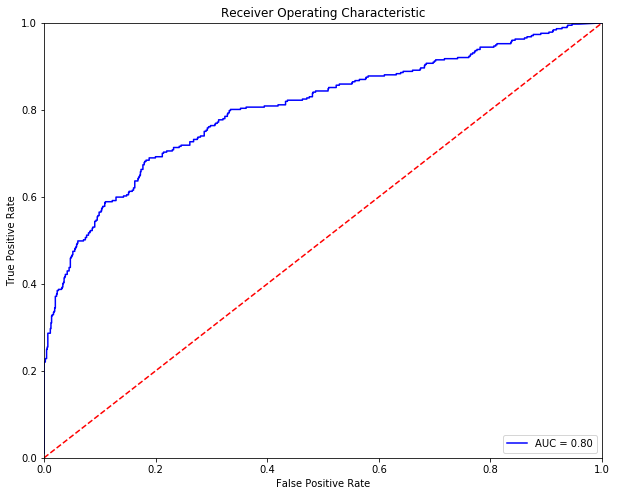

Optimal Threshold is 0.2384950543918796
Accuracy on test data is: 0.731284475965327


Predicted  False  True  __all__
Actual                         
False        653   239      892
True         102   275      377
__all__      755   514     1269

In [51]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [52]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.2 Logistic Regression

In [53]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.3,False,True,0.7,10000,ovr,l2,sag,0.1


Accuracy of the  Logistic  model for the training data is: 0.7863618446984627

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3297   251     3548
True         833   693     1526
__all__     4130   944     5074

Accuracy of the  Logistic  model for test data is: 0.7691095350669819

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        823    69      892
True         224   153      377
__all__     1047   222     1269

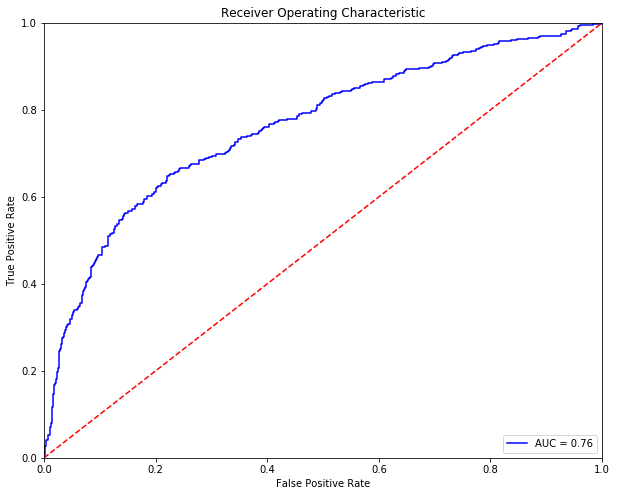

Optimal Threshold is 0.28825455428070024
Accuracy on test data is: 0.6934594168636722


Predicted  False  True  __all__
Actual                         
False        618   274      892
True         115   262      377
__all__      733   536     1269

In [54]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [55]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.3 Random Forest CLassifier 

In [56]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.6992510839574301

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          3548  0     3548
1          1526  0     1526
__all__    5074  0     5074

Accuracy of the  Random Forest Trees  model for test data is: 0.7029156816390859

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0           892  0      892
1           377  0      377
__all__    1269  0     1269

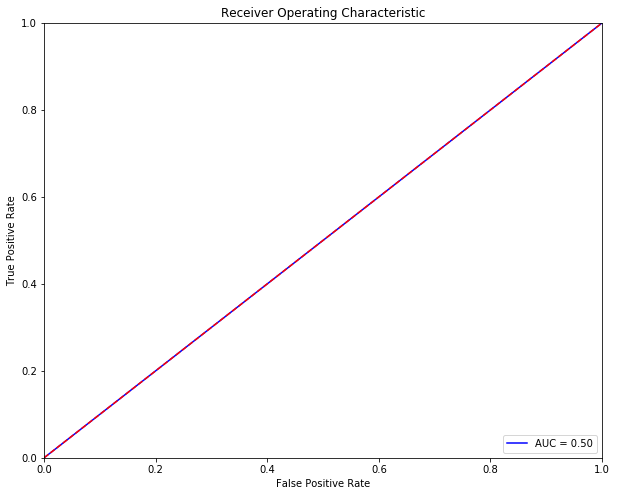

Optimal Threshold is 1.3008691367757192
Accuracy on test data is: 0.7029156816390859


Predicted   0.0  1.0  __all__
Actual                       
0.0         892    0      892
1.0         377    0      377
__all__    1269    0     1269

In [57]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [58]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

3548
0
0
3548
1526
0
0
1526
1.0
0.0
0.0
1.0
892
0
0
892
377
0
0
377
1.0
0.0
0.0
1.0
892
0
0
892
377
0
0
377
1.0
0.0
0.0
1.0


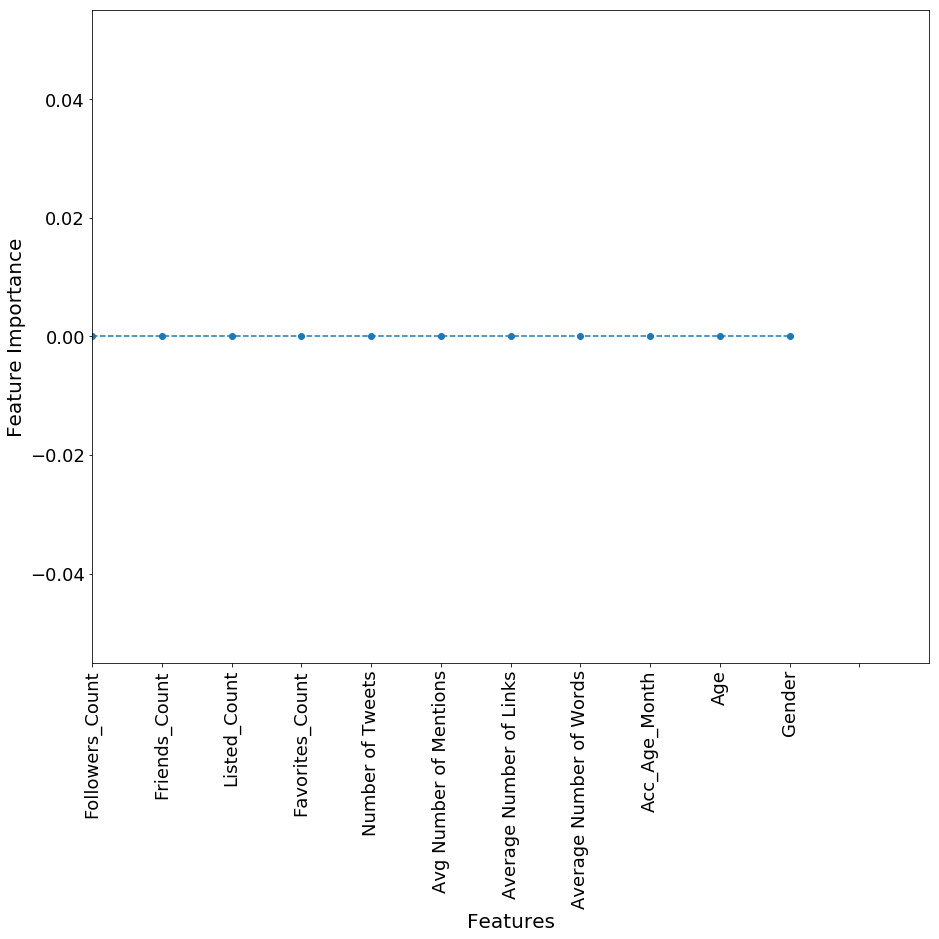

In [59]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [60]:
pd.Series(rf.feature_importances_,index=columns)

Followers_Count            0.0
Friends_Count              0.0
Listed_Count               0.0
Favorites_Count            0.0
Number of Tweets           0.0
Avg Number of Mentions     0.0
Average Number of Links    0.0
Average Number of Words    0.0
Acc_Age_Month              0.0
Age                        0.0
Gender                     0.0
dtype: float64

##### 1.3.4 AdaBoost Classifier 

In [61]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8427276310603075

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3403   145     3548
True         653   873     1526
__all__     4056  1018     5074

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8353033884948778

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        842    50      892
True         159   218      377
__all__     1001   268     1269

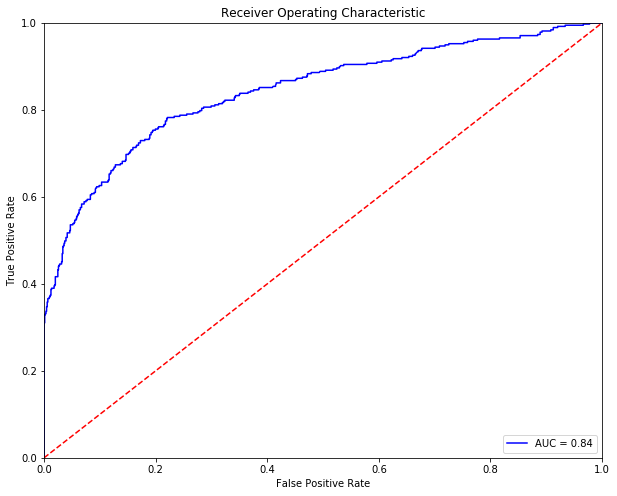

Optimal Threshold is 0.4934061618865381
Accuracy on test data is: 0.7793538219070134


Predicted  False  True  __all__
Actual                         
False        696   196      892
True          84   293      377
__all__      780   489     1269

In [62]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [63]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

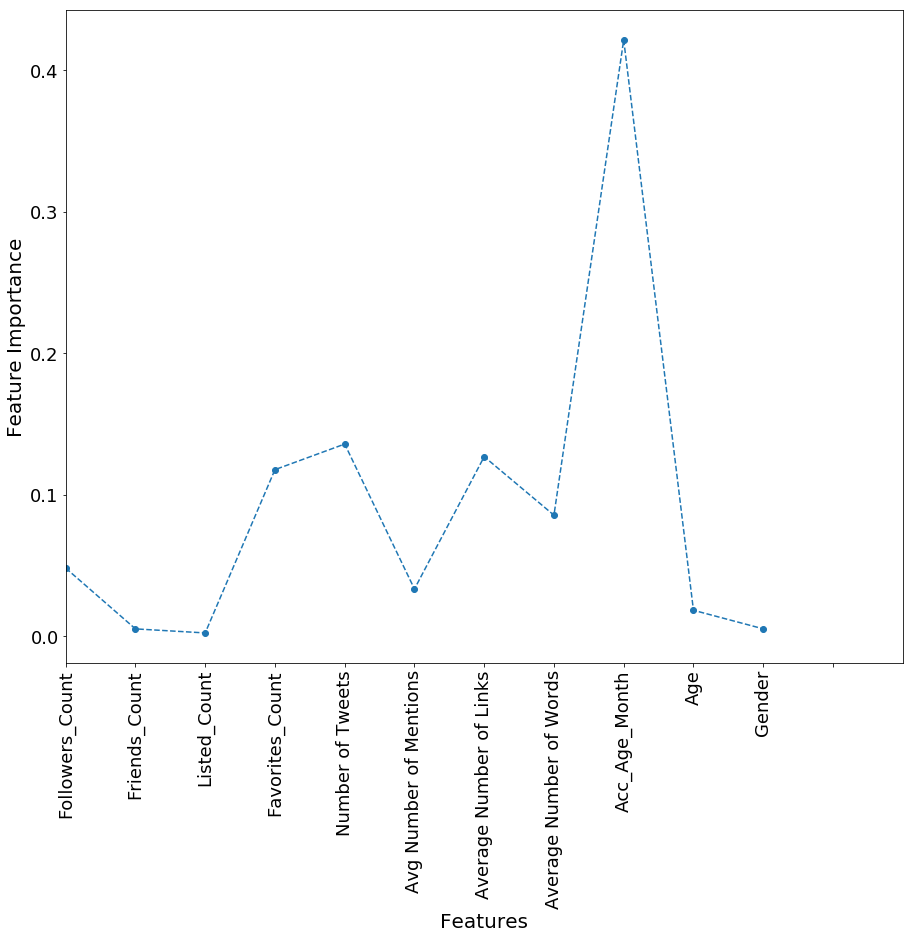

In [64]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [65]:
pd.Series(ada.feature_importances_,index=columns)

Followers_Count            0.048148
Friends_Count              0.005188
Listed_Count               0.002332
Favorites_Count            0.117724
Number of Tweets           0.135808
Avg Number of Mentions     0.033380
Average Number of Links    0.126890
Average Number of Words    0.085539
Acc_Age_Month              0.421412
Age                        0.018349
Gender                     0.005230
dtype: float64

##### 1.3.5 GradientBoosting Classifier

In [66]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,20,0.2,150,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8626330311391407

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3433   115     3548
True         582   944     1526
__all__     4015  1059     5074

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.843183609141056

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        843    49      892
True         150   227      377
__all__      993   276     1269

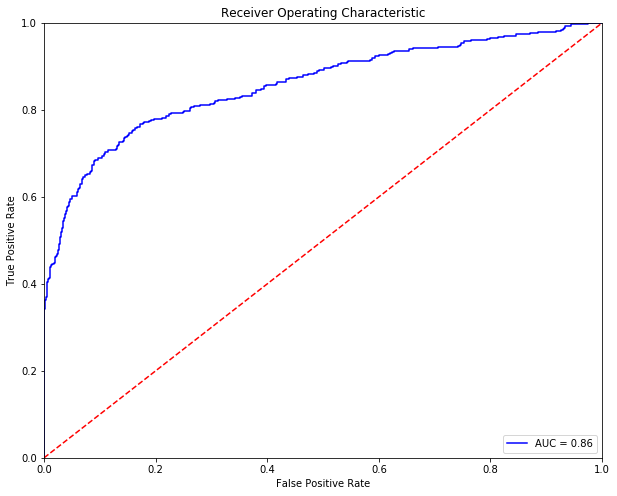

Optimal Threshold is 0.2299191792225014
Accuracy on test data is: 0.7825059101654847


Predicted  False  True  __all__
Actual                         
False        698   194      892
True          82   295      377
__all__      780   489     1269

In [67]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [68]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

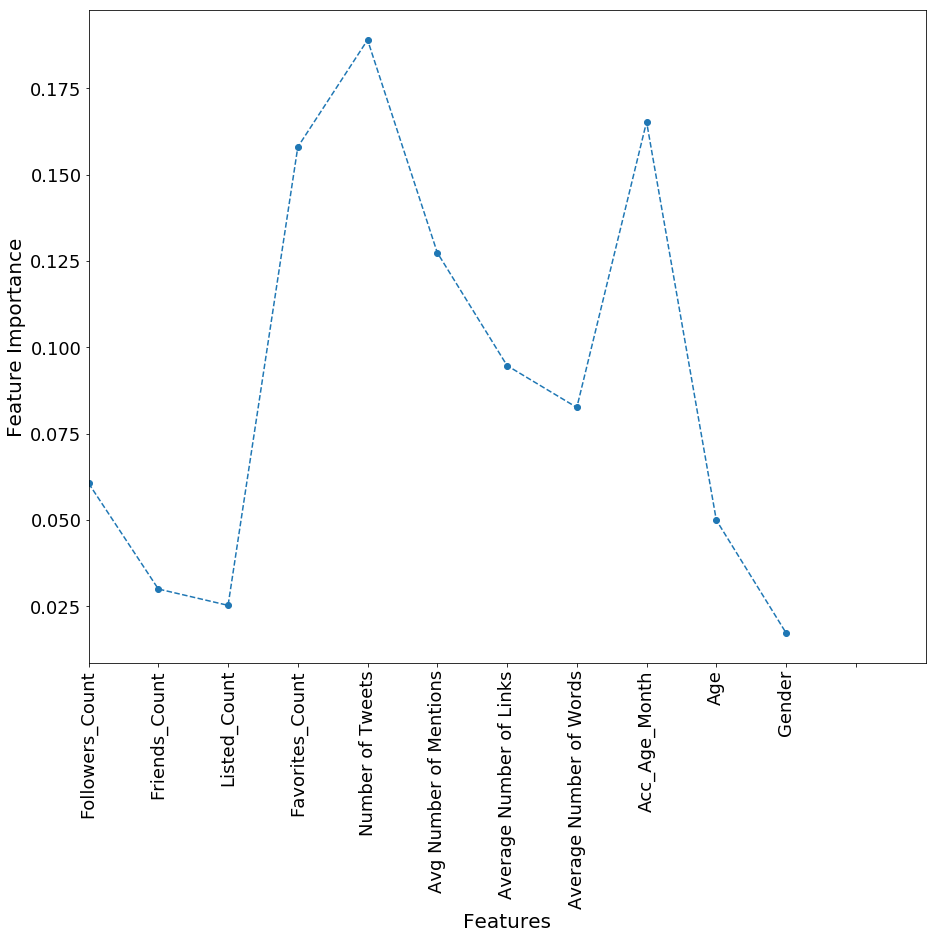

In [69]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [70]:
pd.Series(gbc.feature_importances_,index=columns)

Followers_Count            0.060625
Friends_Count              0.030026
Listed_Count               0.025294
Favorites_Count            0.157975
Number of Tweets           0.188956
Avg Number of Mentions     0.127356
Average Number of Links    0.094690
Average Number of Words    0.082569
Acc_Age_Month              0.165242
Age                        0.049954
Gender                     0.017312
dtype: float64

##### 1.3.6 ExtraTree Classifier

In [71]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,entropy,10,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8490342924714229

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3432   116     3548
True         650   876     1526
__all__     4082   992     5074

Accuracy of the  Extra Decision Tree  model for test data is: 0.8289992119779354

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        850    42      892
True         175   202      377
__all__     1025   244     1269

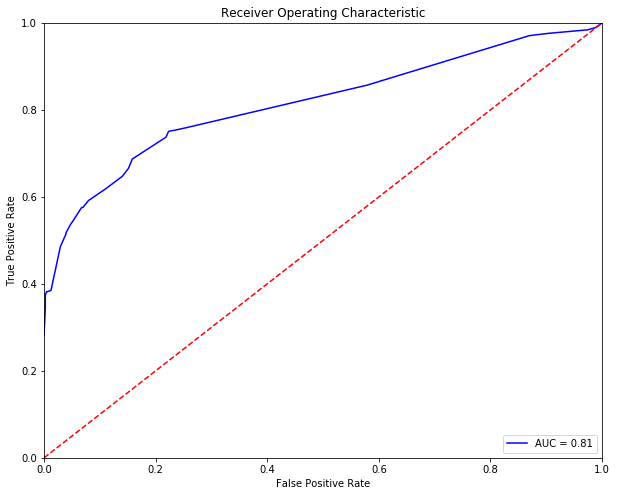

Optimal Threshold is 0.2
Accuracy on test data is: 0.7620173364854216


Predicted  False  True  __all__
Actual                         
False        683   209      892
True          93   284      377
__all__      776   493     1269

In [72]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [73]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

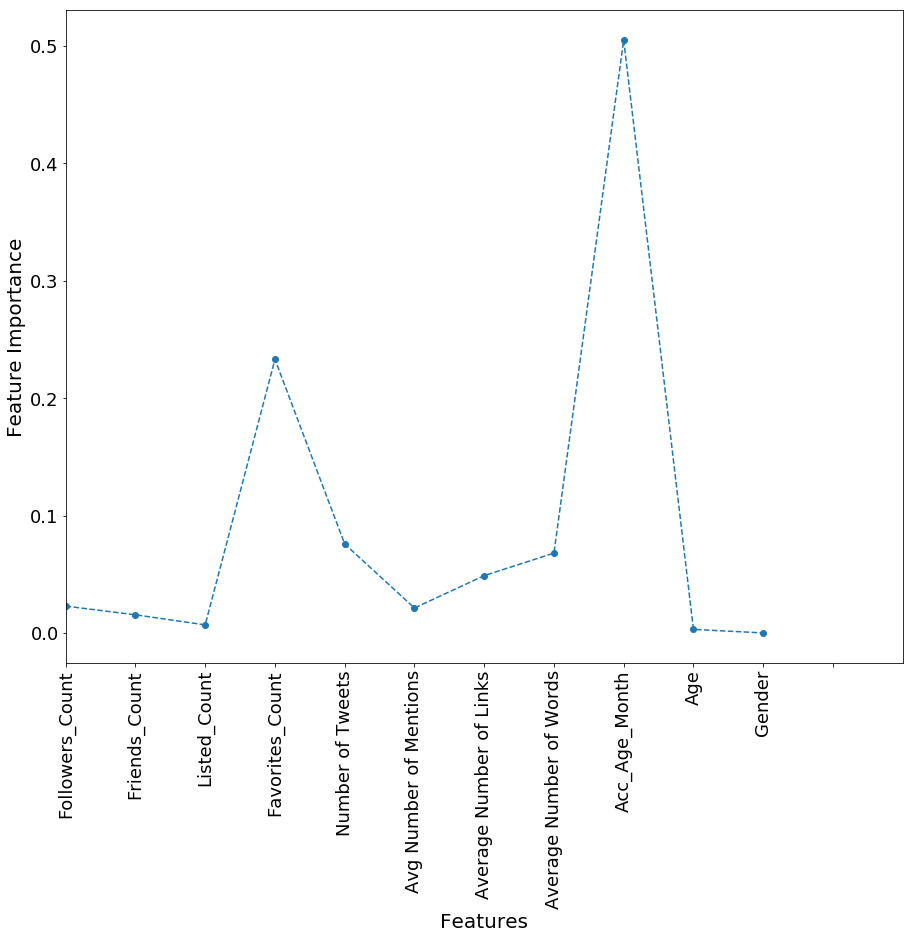

In [74]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [75]:
pd.Series(ext.feature_importances_,index=columns)

Followers_Count            0.022832
Friends_Count              0.015444
Listed_Count               0.006861
Favorites_Count            0.233011
Number of Tweets           0.075751
Avg Number of Mentions     0.021240
Average Number of Links    0.048792
Average Number of Words    0.067971
Acc_Age_Month              0.505093
Age                        0.003004
Gender                     0.000000
dtype: float64

##### 1.3.7 Bagging Classifier

In [76]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.4,500,True,0


Accuracy of the  Bagging  model for the training data is: 0.946787544343713

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3548     0     3548
True         270  1256     1526
__all__     3818  1256     5074

Accuracy of the  Bagging  model for test data is: 0.8289992119779354

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        873    19      892
True         198   179      377
__all__     1071   198     1269

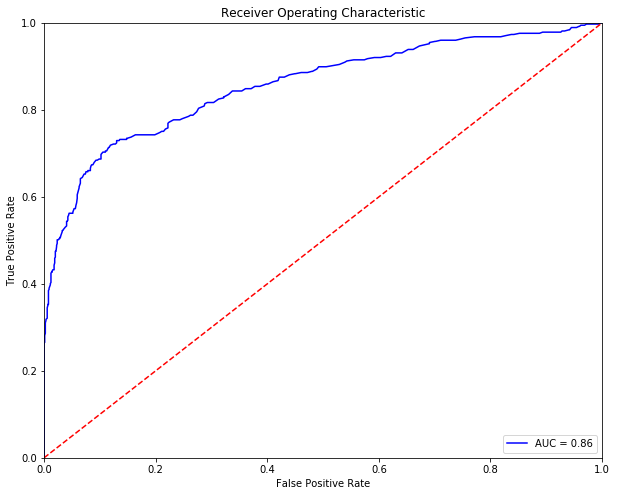

Optimal Threshold is 0.294
Accuracy on test data is: 0.7754137115839244


Predicted  False  True  __all__
Actual                         
False        694   198      892
True          87   290      377
__all__      781   488     1269

In [77]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [78]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.8 Voting Classifier

In [79]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9282617264485613


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       3541     7     3548
True         357  1169     1526
__all__     3898  1176     5074

The test accuracy is: 0.8250591016548463


Predicted  False  True  __all__
Actual                         
False        848    44      892
True         178   199      377
__all__     1026   243     1269

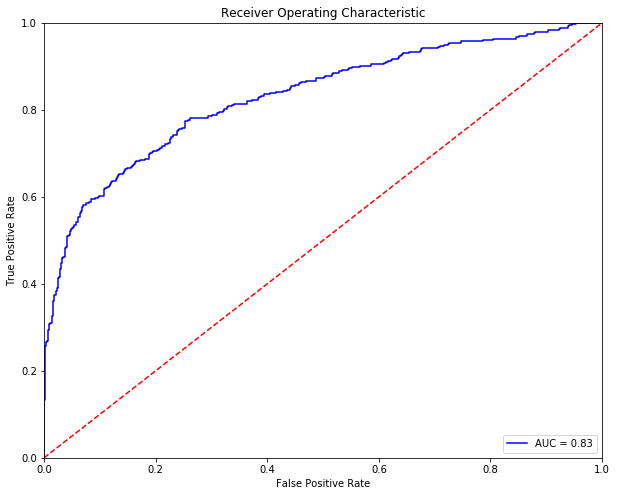

Optimal Threshold is 0.31373127895150577
Accuracy on test data is: 0.7549251379038613


Predicted  False  True  __all__
Actual                         
False        673   219      892
True          92   285      377
__all__      765   504     1269

In [80]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [81]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.9 Deep Learning

In [82]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.882538431217974


Predicted  False  True  __all__
Actual                         
False       3454    94     3548
True         502  1024     1526
__all__     3956  1118     5074

The accuracy of the model on test data is: 0.8045705279747833


Predicted  False  True  __all__
Actual                         
False        822    70      892
True         178   199      377
__all__     1000   269     1269

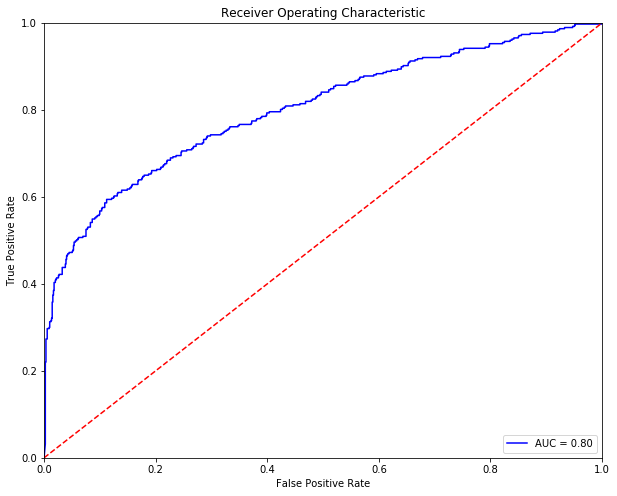

Optimal Threshold is 0.17891055
Accuracy of Logistic Model on training data is: 0.7186761229314421


Predicted  False  True  __all__
Actual                         
False        640   252      892
True         105   272      377
__all__      745   524     1269

In [83]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [84]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.10 Deep Learning with Grid Search

In [85]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


The accuracy of the model on training data is: 0.8175009854158455


Predicted  False  True  __all__
Actual                         
False       3293   255     3548
True         671   855     1526
__all__     3964  1110     5074

The accuracy of the model on test data is: 0.7951142631993696


Predicted  False  True  __all__
Actual                         
False        807    85      892
True         175   202      377
__all__      982   287     1269

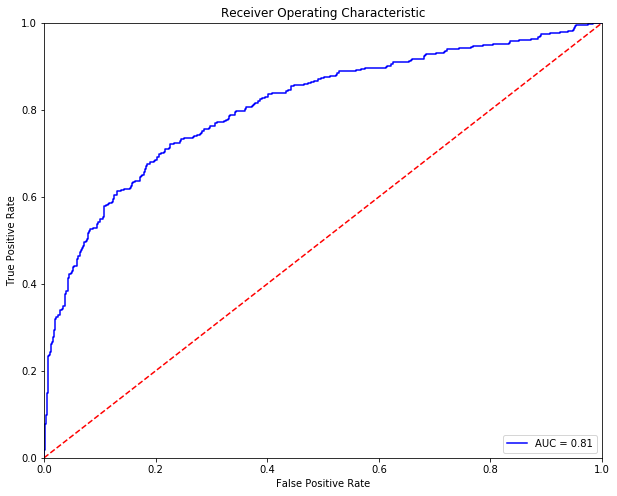

Optimal Threshold is 0.24090187
Accuracy on test data is: 0.7344365642237982


Predicted  False  True  __all__
Actual                         
False        655   237      892
True         100   277      377
__all__      755   514     1269

In [86]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [87]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id='#1.3.1' style="text-decoration : none; color: #000000;">1.3.1 Results </a>

In [88]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1526.000000,3548.000000,0.000000,0.000000,0.000000,0.000000
LogisticRegression,0.786362,693.000000,3297.000000,251.000000,833.000000,0.070744,0.545872
RandomForestClassifier,0.699251,2480.942846,1067.057154,1067.057154,458.942846,0.699251,0.300749
AdaBoostClassifier,0.842728,873.000000,3403.000000,145.000000,653.000000,0.040868,0.427916
GradientBoostingClassifier,0.862633,944.000000,3433.000000,115.000000,582.000000,0.032413,0.381389
ExtraTreeClassifier,0.849034,876.000000,3432.000000,116.000000,650.000000,0.032694,0.425950
BaggingClassifier,0.946788,1256.000000,3548.000000,0.000000,270.000000,0.000000,0.176933
VotingClassifier,0.928262,1169.000000,3541.000000,7.000000,357.000000,0.001973,0.233945
Neural Network-1,0.882538,1024.000000,3454.000000,94.000000,502.000000,0.026494,0.328965


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.799054,159.000000,855.000000,37.000000,218.000000,0.041480,0.578249
LogisticRegression,0.769110,153.000000,823.000000,69.000000,224.000000,0.077354,0.594164
RandomForestClassifier,0.702916,627.000788,264.999212,264.999212,112.000788,0.702916,0.297084
AdaBoostClassifier,0.835303,218.000000,842.000000,50.000000,159.000000,0.056054,0.421751
GradientBoostingClassifier,0.843184,227.000000,843.000000,49.000000,150.000000,0.054933,0.397878
ExtraTreeClassifier,0.828999,202.000000,850.000000,42.000000,175.000000,0.047085,0.464191
BaggingClassifier,0.828999,179.000000,873.000000,19.000000,198.000000,0.021300,0.525199
VotingClassifier,0.825059,199.000000,848.000000,44.000000,178.000000,0.049327,0.472149
Neural Network-1,0.804571,199.000000,822.000000,70.000000,178.000000,0.078475,0.472149


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.731284,275.000000,653.000000,239.000000,102.000000,0.267937,0.270557,0.238495,0.803129
LogisticRegression,0.693459,262.000000,618.000000,274.000000,115.000000,0.307175,0.305040,0.288255,0.762849
RandomForestClassifier,0.702916,627.000788,264.999212,264.999212,112.000788,0.702916,0.297084,1.300869,0.500000
AdaBoostClassifier,0.779354,293.000000,696.000000,196.000000,84.000000,0.219731,0.222812,0.493406,0.843562
GradientBoostingClassifier,0.782506,295.000000,698.000000,194.000000,82.000000,0.217489,0.217507,0.229919,0.856904
ExtraTreeClassifier,0.762017,284.000000,683.000000,209.000000,93.000000,0.234305,0.246684,0.200000,0.814520
BaggingClassifier,0.775414,290.000000,694.000000,198.000000,87.000000,0.221973,0.230769,0.294000,0.856441
VotingClassifier,0.754925,285.000000,673.000000,219.000000,92.000000,0.245516,0.244032,0.313731,0.830474
Neural Network-1,0.718676,272.000000,640.000000,252.000000,105.000000,0.282511,0.278515,0.178911,0.800564


### <a id='2' style="text-decoration : none; color: #000000;"> 2 Vulnerable/Control 50:50</a>
#### <a id='2.1' style="text-decoration : none; color: #000000;"> 2.1 Loading Data </a>

In [104]:
nm=df2[df2.Malicious==0]
m=df2[df2.Malicious==1]

df2=m.append(nm.sample(frac=((len(m)/0.5)*0.5)/len(nm),random_state=10))

In [105]:
print("The number of Vulnerable/Control Cases:")
df2.Malicious.value_counts()

The number of Vulnerable/Control Cases:


1    1903
0    1903
Name: Malicious, dtype: int64

In [106]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

#### <a id='2.2' style="text-decoration : none; color: #000000;"> 2.2  70: 30 Train Test split </a>

In [107]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [108]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 2.2.1 KNN

In [109]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,20,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1337     0     1337
True           0  1327     1327
__all__     1337  1327     2664

Accuracy of the  KNN  model for test data is: 0.7302977232924693

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        477    89      566
True         219   357      576
__all__      696   446     1142

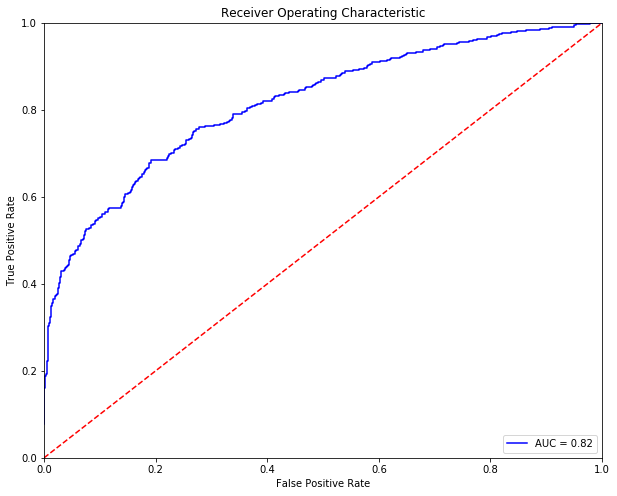

Optimal Threshold is 0.41038435637205695
Accuracy on test data is: 0.7355516637478109


Predicted  False  True  __all__
Actual                         
False        417   149      566
True         153   423      576
__all__      570   572     1142

In [110]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [111]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.2 Logistic Regression

In [112]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.5,10000,ovr,l2,newton-cg,1e-05


Accuracy of the  Logistic  model for the training data is: 0.7278528528528528

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1030   307     1337
True         418   909     1327
__all__     1448  1216     2664

Accuracy of the  Logistic  model for test data is: 0.7206654991243433

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        428   138      566
True         181   395      576
__all__      609   533     1142

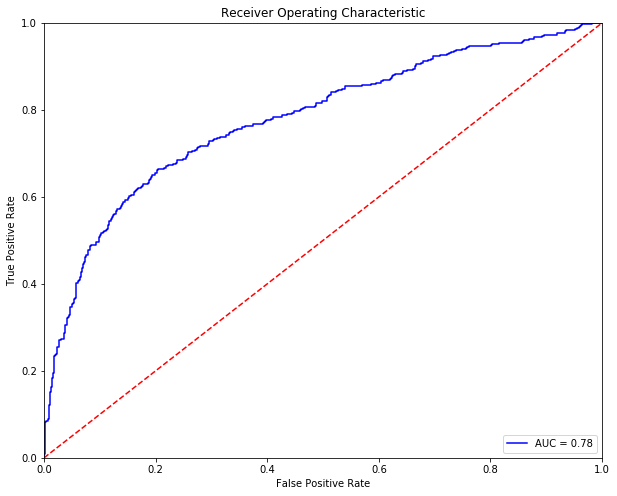

Optimal Threshold is 0.47143888569642545
Accuracy on test data is: 0.7180385288966725


Predicted  False  True  __all__
Actual                         
False        408   158      566
True         164   412      576
__all__      572   570     1142

In [113]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [114]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.3 RandomFOrest Classifier

In [115]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,entropy,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.6486486486486487

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1336     1     1337
True         935   392     1327
__all__     2271   393     2664

Accuracy of the  Random Forest Trees  model for test data is: 0.638353765323993

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        566     0      566
True         413   163      576
__all__      979   163     1142

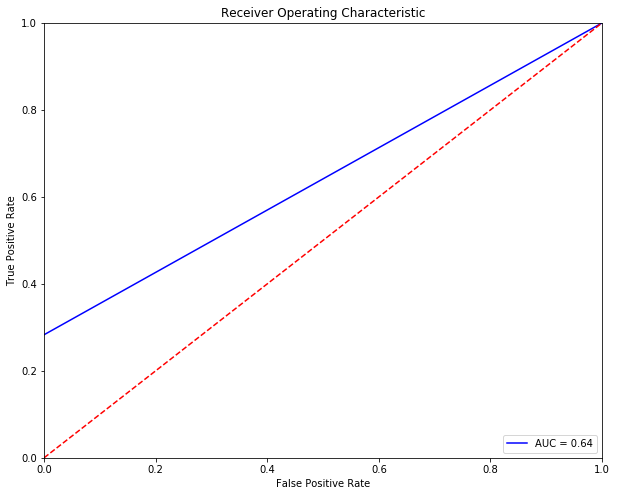

Optimal Threshold is 0.6281925675675676
Accuracy on test data is: 0.4956217162872154


Predicted   0.0  1.0  __all__
Actual                       
0.0         566    0      566
1.0         576    0      576
__all__    1142    0     1142

In [116]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [117]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

566
0
0
566
576
0
0
576
1.0
0.0
0.0
1.0


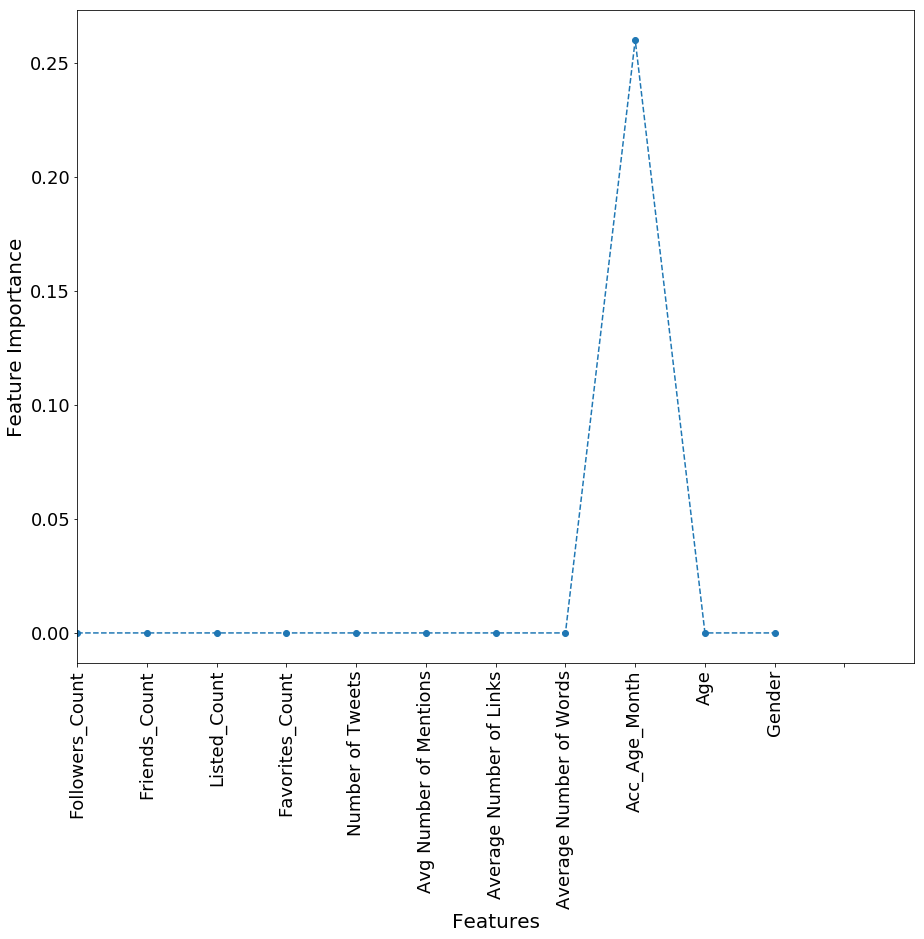

In [118]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [119]:
pd.Series(rf.feature_importances_,index=columns)

Followers_Count            0.00
Friends_Count              0.00
Listed_Count               0.00
Favorites_Count            0.00
Number of Tweets           0.00
Avg Number of Mentions     0.00
Average Number of Links    0.00
Average Number of Words    0.00
Acc_Age_Month              0.26
Age                        0.00
Gender                     0.00
dtype: float64

##### 2.2.4 Ada Boost Classifier

In [120]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8003003003003003

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1151   186     1337
True         346   981     1327
__all__     1497  1167     2664

Accuracy of the  AdaBoostClassifier  model for test data is: 0.7784588441330998

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        477    89      566
True         164   412      576
__all__      641   501     1142

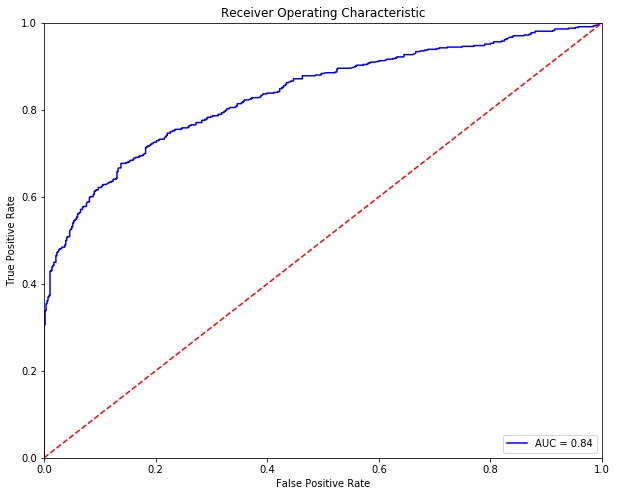

Optimal Threshold is 0.5021382742568776
Accuracy on test data is: 0.7556917688266199


Predicted  False  True  __all__
Actual                         
False        428   138      566
True         141   435      576
__all__      569   573     1142

In [121]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [122]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

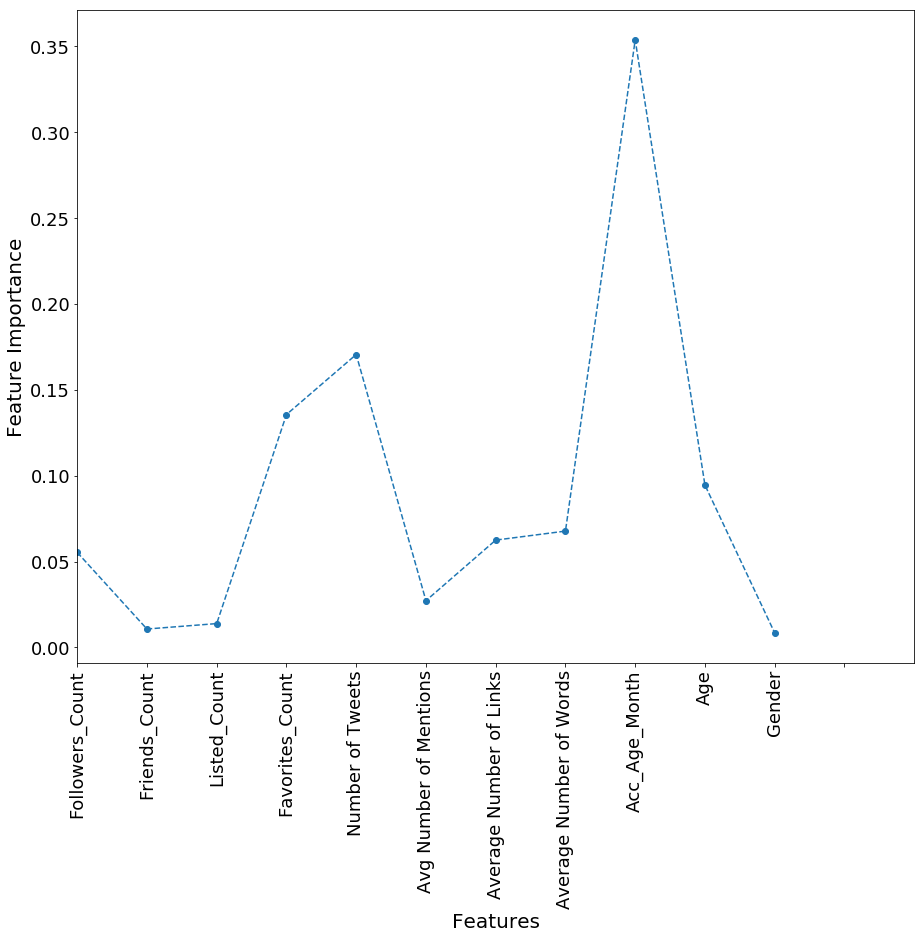

In [123]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [124]:
pd.Series(ada.feature_importances_,index=columns)

Followers_Count            0.055309
Friends_Count              0.010687
Listed_Count               0.013847
Favorites_Count            0.135578
Number of Tweets           0.170549
Avg Number of Mentions     0.027191
Average Number of Links    0.062471
Average Number of Words    0.067711
Acc_Age_Month              0.353755
Age                        0.094493
Gender                     0.008410
dtype: float64

##### 2.2.5 Gradient Boosting Classifier

In [125]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,exponential,10,0.3,150,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8329579579579579

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1196   141     1337
True         304  1023     1327
__all__     1500  1164     2664

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.7942206654991243

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        492    74      566
True         161   415      576
__all__      653   489     1142

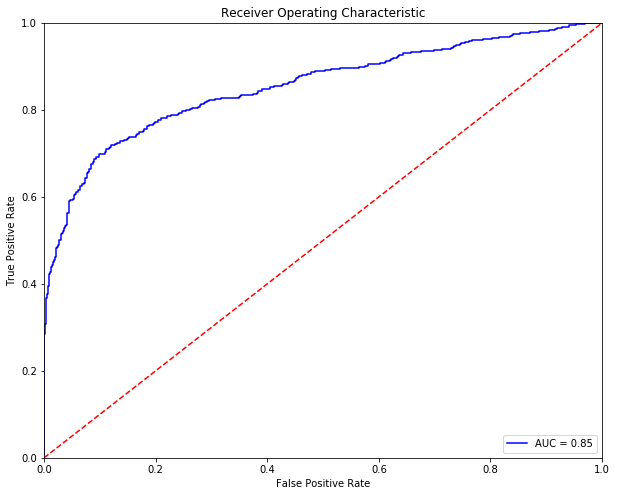

Optimal Threshold is 0.40517820627560286
Accuracy on test data is: 0.7810858143607706


Predicted  False  True  __all__
Actual                         
False        442   124      566
True         126   450      576
__all__      568   574     1142

In [126]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [127]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

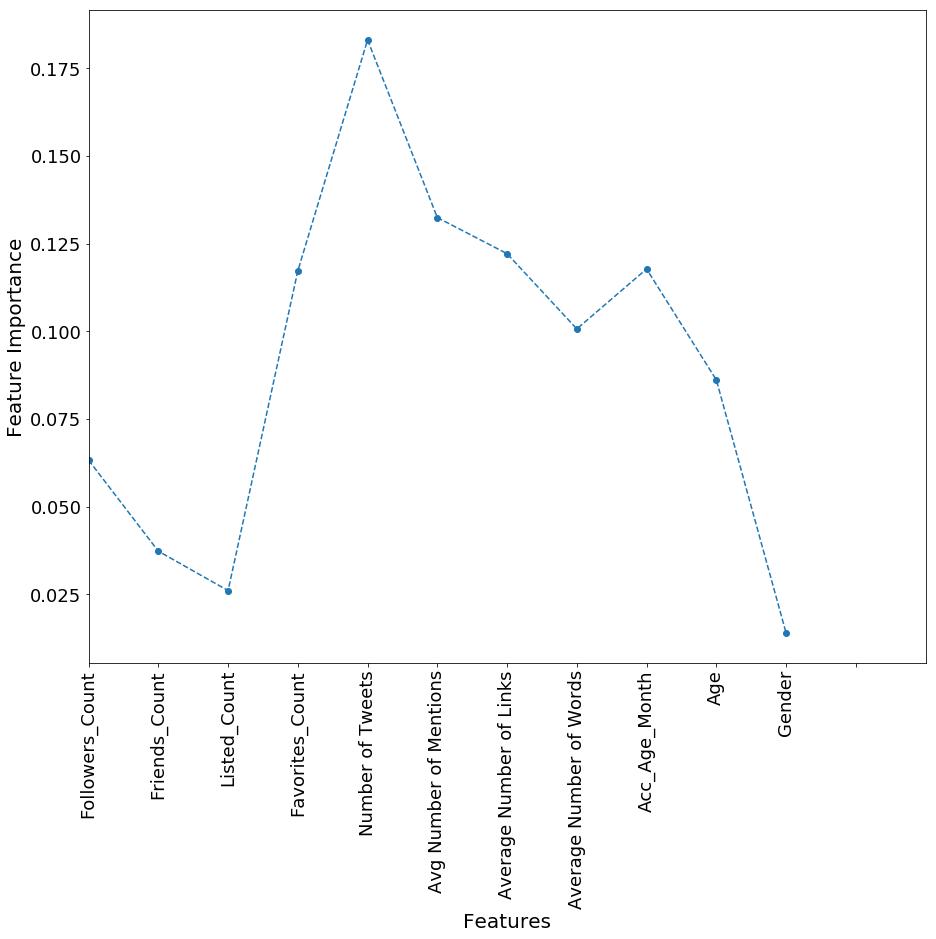

In [128]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [129]:
pd.Series(gbc.feature_importances_,index=columns)

Followers_Count            0.063251
Friends_Count              0.037283
Listed_Count               0.026036
Favorites_Count            0.117243
Number of Tweets           0.183099
Avg Number of Mentions     0.132437
Average Number of Links    0.122126
Average Number of Words    0.100674
Acc_Age_Month              0.117764
Age                        0.086126
Gender                     0.013962
dtype: float64

##### 2.2.6 Extra Tree classifier

In [130]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,entropy,10,auto,0.001,2,5,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8213213213213213

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1186   151     1337
True         325  1002     1327
__all__     1511  1153     2664

Accuracy of the  Extra Decision Tree  model for test data is: 0.7714535901926445

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        484    82      566
True         179   397      576
__all__      663   479     1142

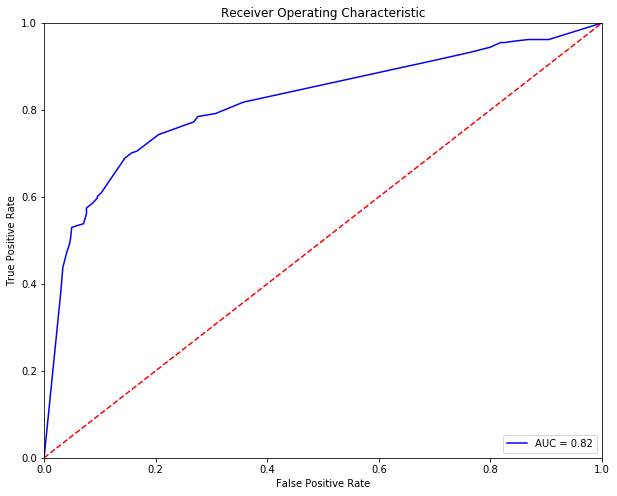

Optimal Threshold is 0.36363636363636365
Accuracy on test data is: 0.7688266199649737


Predicted  False  True  __all__
Actual                         
False        450   116      566
True         148   428      576
__all__      598   544     1142

In [131]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [132]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

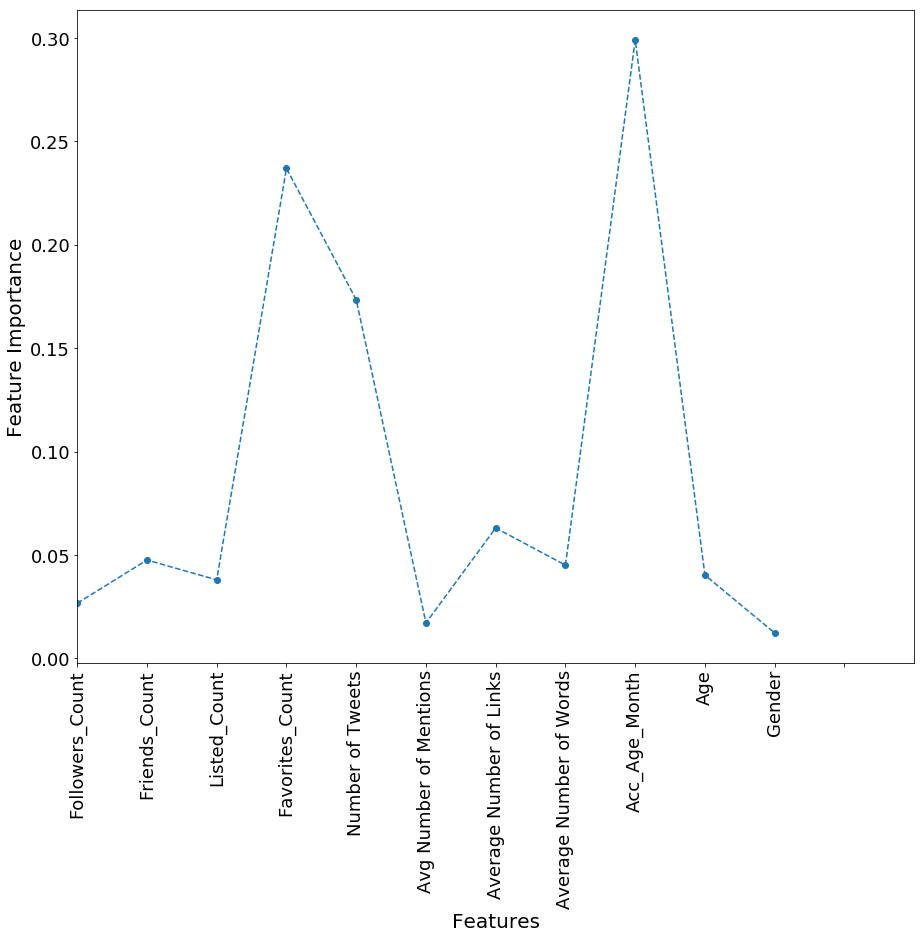

In [133]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [134]:
pd.Series(ext.feature_importances_,index=columns)

Followers_Count            0.026702
Friends_Count              0.047592
Listed_Count               0.038017
Favorites_Count            0.237006
Number of Tweets           0.173496
Avg Number of Mentions     0.017185
Average Number of Links    0.063116
Average Number of Words    0.045125
Acc_Age_Month              0.299113
Age                        0.040301
Gender                     0.012348
dtype: float64

##### 2.2.7 Bagging Classifier

In [135]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.4,500,True,0


Accuracy of the  Bagging  model for the training data is: 0.9876126126126126

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1330     7     1337
True          26  1301     1327
__all__     1356  1308     2664

Accuracy of the  Bagging  model for test data is: 0.7863397548161121

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        489    77      566
True         167   409      576
__all__      656   486     1142

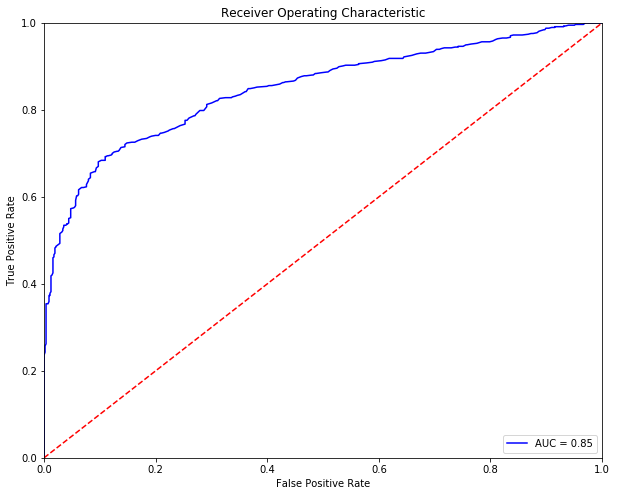

Optimal Threshold is 0.456
Accuracy on test data is: 0.7609457092819615


Predicted  False  True  __all__
Actual                         
False        431   135      566
True         138   438      576
__all__      569   573     1142

In [136]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [137]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.8 Voting Classifier

In [138]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9703453453453453


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       1322    15     1337
True          64  1263     1327
__all__     1386  1278     2664

The test accuracy is: 0.7705779334500875


Predicted  False  True  __all__
Actual                         
False        477    89      566
True         173   403      576
__all__      650   492     1142

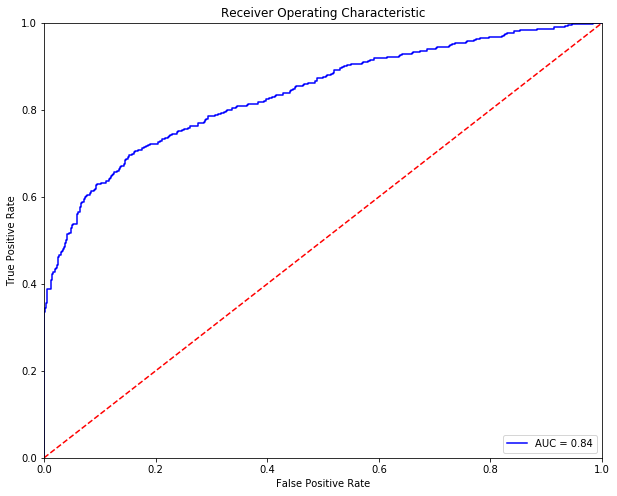

Optimal Threshold is 0.46104525593183077
Accuracy on test data is: 0.7521891418563923


Predicted  False  True  __all__
Actual                         
False        426   140      566
True         143   433      576
__all__      569   573     1142

In [139]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [140]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### 2.2.9 Deep Learning

In [141]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8603603603603603


Predicted  False  True  __all__
Actual                         
False       1210   127     1337
True         245  1082     1327
__all__     1455  1209     2664

The accuracy of the model on test data is: 0.7478108581436077


Predicted  False  True  __all__
Actual                         
False        446   120      566
True         168   408      576
__all__      614   528     1142

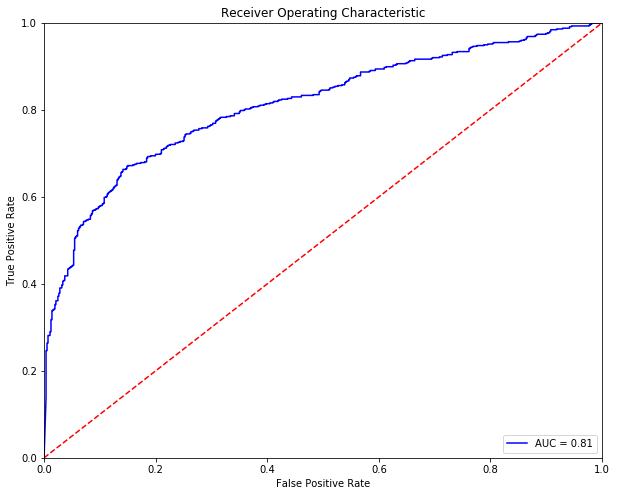

Optimal Threshold is 0.42447335
Accuracy of Logistic Model on training data is: 0.7443082311733801


Predicted  False  True  __all__
Actual                         
False        422   144      566
True         148   428      576
__all__      570   572     1142

In [142]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [143]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.10 Deep Learning with Grid Search

In [144]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.8min finished


The accuracy of the model on training data is: 0.75


Predicted  False  True  __all__
Actual                         
False       1062   275     1337
True         391   936     1327
__all__     1453  1211     2664

The accuracy of the model on test data is: 0.7364273204903677


Predicted  False  True  __all__
Actual                         
False        434   132      566
True         169   407      576
__all__      603   539     1142

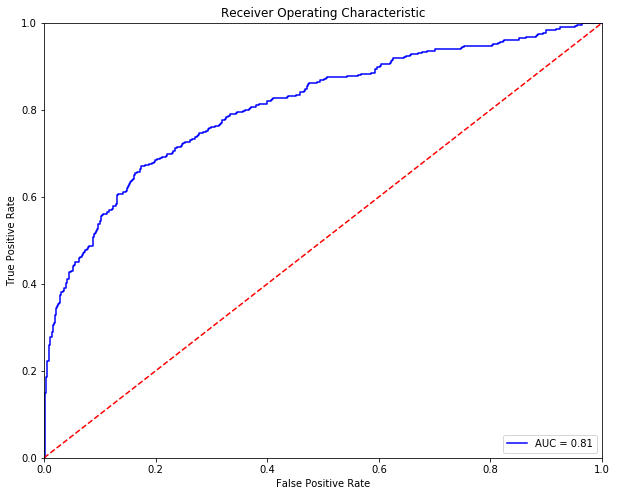

Optimal Threshold is 0.45714664
Accuracy on test data is: 0.7329246935201401


Predicted  False  True  __all__
Actual                         
False        416   150      566
True         155   421      576
__all__      571   571     1142

In [145]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [146]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id'#2.2.1' style="text-decoration : none; color: #000000;">2.2.1 Results </a></ol></ul>

In [147]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1327.0,1337.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.727853,909.0,1030.0,307.0,418.0,0.229619,0.314996
RandomForestClassifier,0.648649,392.0,1336.0,1.0,935.0,0.000748,0.704597
AdaBoostClassifier,0.800300,981.0,1151.0,186.0,346.0,0.139117,0.260739
GradientBoostingClassifier,0.832958,1023.0,1196.0,141.0,304.0,0.105460,0.229088
ExtraTreeClassifier,0.821321,1002.0,1186.0,151.0,325.0,0.112939,0.244913
BaggingClassifier,0.987613,1301.0,1330.0,7.0,26.0,0.005236,0.019593
VotingClassifier,0.970345,1263.0,1322.0,15.0,64.0,0.011219,0.048229
Neural Network-1,0.860360,1082.0,1210.0,127.0,245.0,0.094989,0.184627


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.730298,357.0,477.0,89.0,219.0,0.157244,0.380208
LogisticRegression,0.720665,395.0,428.0,138.0,181.0,0.243816,0.314236
RandomForestClassifier,0.638354,163.0,566.0,0.0,413.0,0.000000,0.717014
AdaBoostClassifier,0.778459,412.0,477.0,89.0,164.0,0.157244,0.284722
GradientBoostingClassifier,0.794221,415.0,492.0,74.0,161.0,0.130742,0.279514
ExtraTreeClassifier,0.771454,397.0,484.0,82.0,179.0,0.144876,0.310764
BaggingClassifier,0.786340,409.0,489.0,77.0,167.0,0.136042,0.289931
VotingClassifier,0.770578,403.0,477.0,89.0,173.0,0.157244,0.300347
Neural Network-1,0.747811,408.0,446.0,120.0,168.0,0.212014,0.291667


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.735552,423.000000,417.000000,149.000000,153.000000,0.263251,0.265625,0.410384,0.815543
LogisticRegression,0.718039,412.000000,408.000000,158.000000,164.000000,0.279152,0.284722,0.471439,0.779115
RandomForestClassifier,0.495622,280.521891,285.478109,285.478109,290.521891,0.495622,0.504378,0.628193,0.641493
AdaBoostClassifier,0.755692,435.000000,428.000000,138.000000,141.000000,0.243816,0.244792,0.502138,0.835221
GradientBoostingClassifier,0.781086,450.000000,442.000000,124.000000,126.000000,0.219081,0.218750,0.405178,0.853639
ExtraTreeClassifier,0.768827,428.000000,450.000000,116.000000,148.000000,0.204947,0.256944,0.363636,0.817432
BaggingClassifier,0.760946,438.000000,431.000000,135.000000,138.000000,0.238516,0.239583,0.456000,0.848455
VotingClassifier,0.752189,433.000000,426.000000,140.000000,143.000000,0.247350,0.248264,0.461045,0.836551
Neural Network-1,0.744308,428.000000,422.000000,144.000000,148.000000,0.254417,0.256944,0.424473,0.811831


###  <a id='2.3' style="text-decoration : none; color: #000000;"> 2.3  80:20 Train Test split </a>

In [148]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [149]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 2.3.1 KNN

In [150]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,20,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1524     0     1524
True           0  1520     1520
__all__     1524  1520     3044

Accuracy of the  KNN  model for test data is: 0.7454068241469817

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        317    62      379
True         132   251      383
__all__      449   313      762

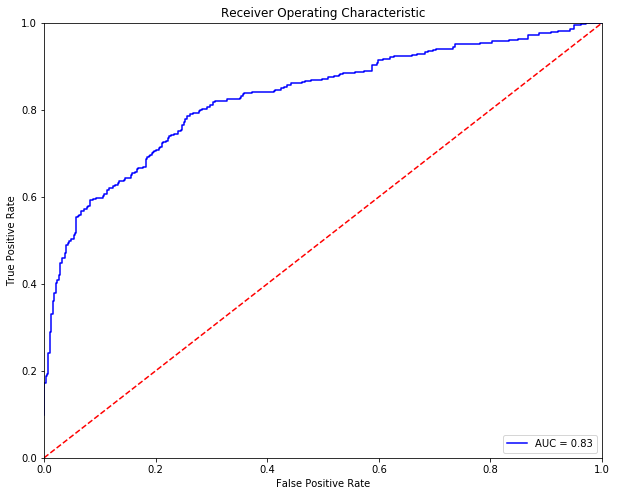

Optimal Threshold is 0.4091388617611284
Accuracy on test data is: 0.7532808398950132


Predicted  False  True  __all__
Actual                         
False        286    93      379
True          95   288      383
__all__      381   381      762

In [151]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [152]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.3 Logistic Regression

In [153]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.5,10000,multinomial,l2,sag,0.001


Accuracy of the  Logistic  model for the training data is: 0.7247043363994744

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1170   354     1524
True         484  1036     1520
__all__     1654  1390     3044

Accuracy of the  Logistic  model for test data is: 0.7296587926509186

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        292    87      379
True         119   264      383
__all__      411   351      762

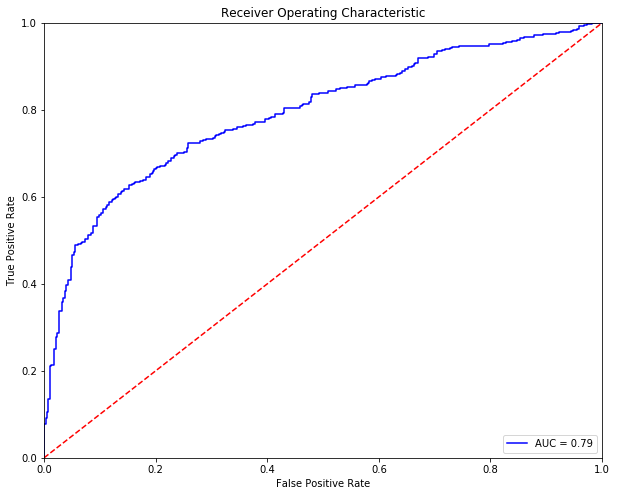

Optimal Threshold is 0.48320043973610105
Accuracy on test data is: 0.7230971128608924


Predicted  False  True  __all__
Actual                         
False        274   105      379
True         106   277      383
__all__      380   382      762

In [154]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [155]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.3 Random Forest CLassifiere

In [156]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,entropy,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.6435611038107752

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1523     1     1524
True        1084   436     1520
__all__     2607   437     3044

Accuracy of the  Random Forest Trees  model for test data is: 0.6535433070866141

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        379     0      379
True         264   119      383
__all__      643   119      762

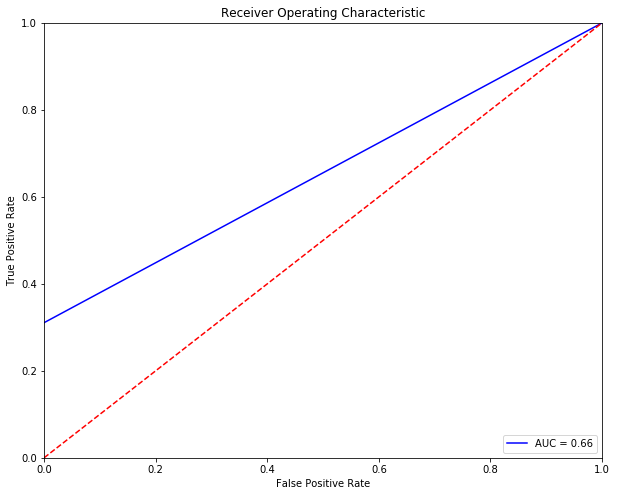

Optimal Threshold is 0.6293922470433639
Accuracy on test data is: 0.4973753280839895


Predicted  0.0  1.0  __all__
Actual                      
0.0        379    0      379
1.0        383    0      383
__all__    762    0      762

In [157]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [158]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

379
0
0
379
383
0
0
383
1.0
0.0
0.0
1.0


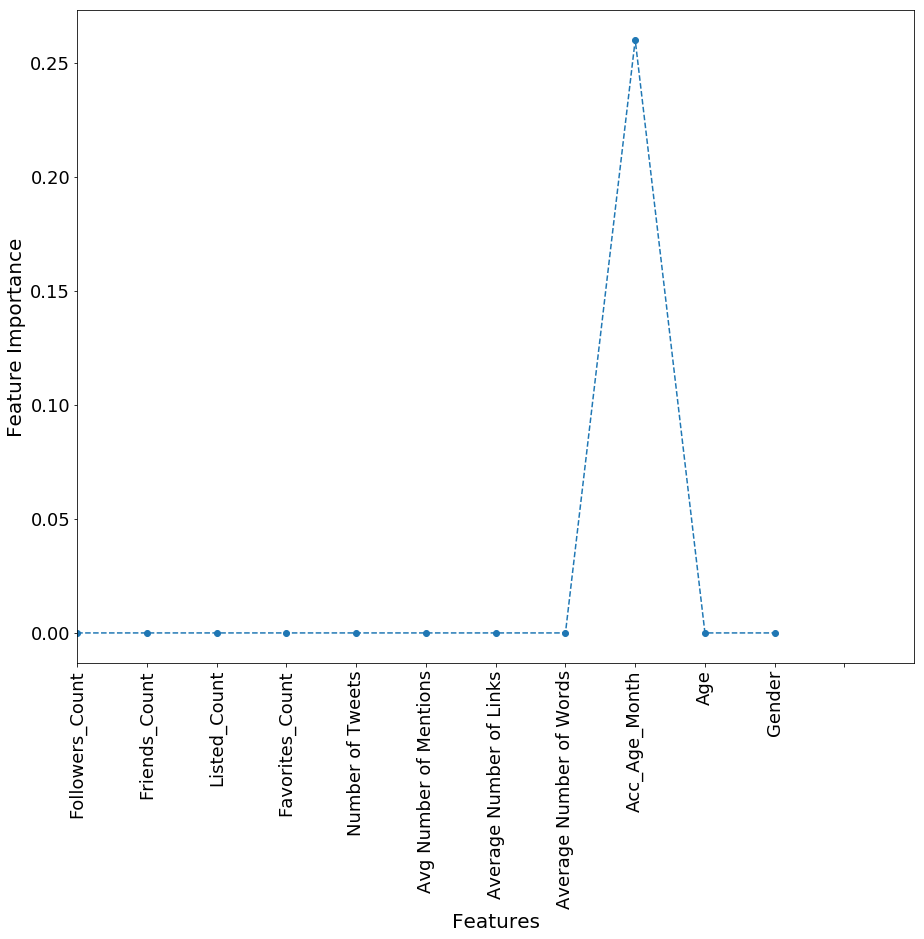

In [159]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [160]:
pd.Series(rf.feature_importances_,index=columns)

Followers_Count            0.00
Friends_Count              0.00
Listed_Count               0.00
Favorites_Count            0.00
Number of Tweets           0.00
Avg Number of Mentions     0.00
Average Number of Links    0.00
Average Number of Words    0.00
Acc_Age_Month              0.26
Age                        0.00
Gender                     0.00
dtype: float64

##### 2.3.4 AdaBoost Classifier

In [161]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1.5,150,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.7913929040735874

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1283   241     1524
True         394  1126     1520
__all__     1677  1367     3044

Accuracy of the  AdaBoostClassifier  model for test data is: 0.7677165354330708

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        302    77      379
True         100   283      383
__all__      402   360      762

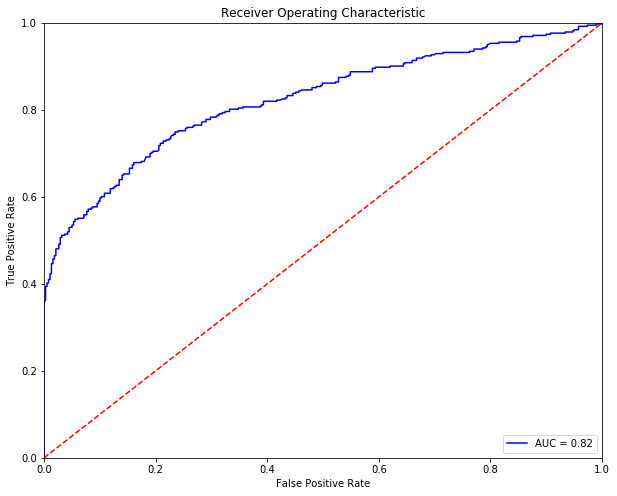

Optimal Threshold is 0.5017566553808773
Accuracy on test data is: 0.7506561679790026


Predicted  False  True  __all__
Actual                         
False        284    95      379
True          95   288      383
__all__      379   383      762

In [162]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [163]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

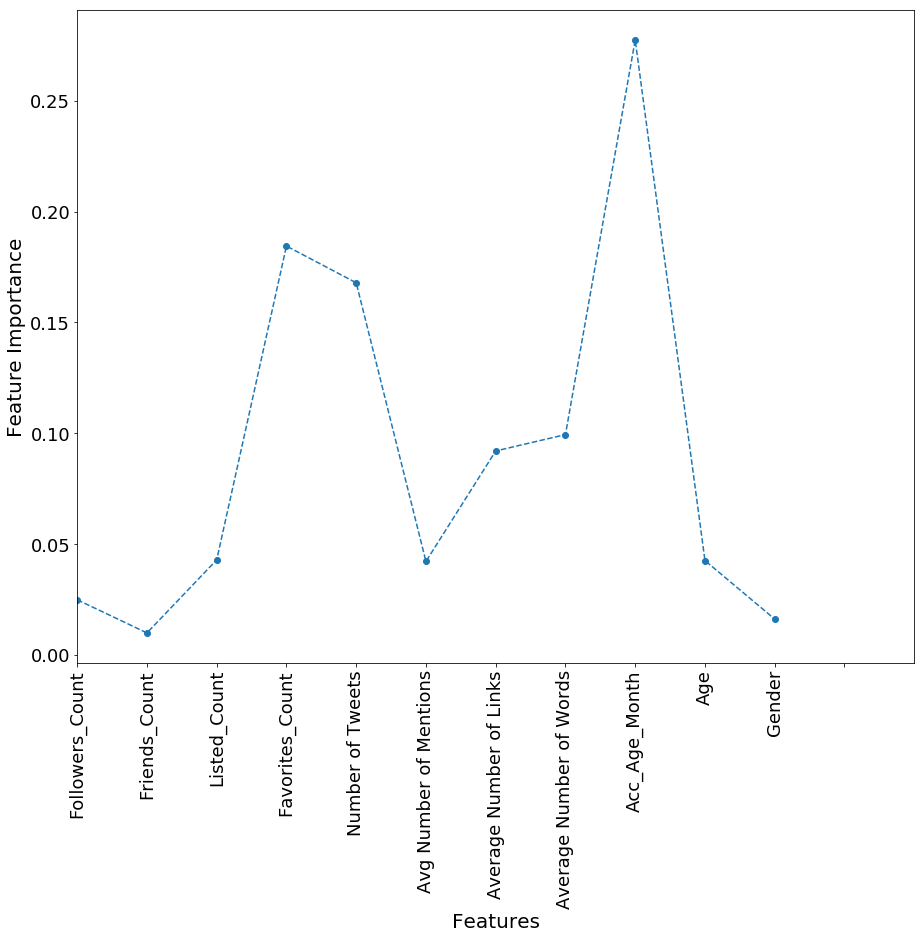

In [164]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [165]:
pd.Series(ada.feature_importances_,index=columns)

Followers_Count            0.024913
Friends_Count              0.009954
Listed_Count               0.042909
Favorites_Count            0.184458
Number of Tweets           0.167889
Avg Number of Mentions     0.042197
Average Number of Links    0.092028
Average Number of Words    0.099413
Acc_Age_Month              0.277434
Age                        0.042614
Gender                     0.016192
dtype: float64

##### 2.3.5 Gradient Boosting Classifier

In [166]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,15,0.3,150,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8291721419185283

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1358   166     1524
True         354  1166     1520
__all__     1712  1332     3044

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8057742782152231

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        334    45      379
True         103   280      383
__all__      437   325      762

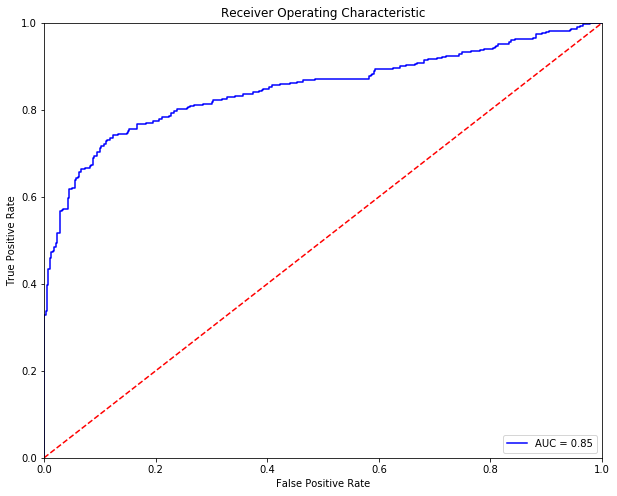

Optimal Threshold is 0.4054801446044486
Accuracy on test data is: 0.7847769028871391


Predicted  False  True  __all__
Actual                         
False        299    80      379
True          84   299      383
__all__      383   379      762

In [167]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [168]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

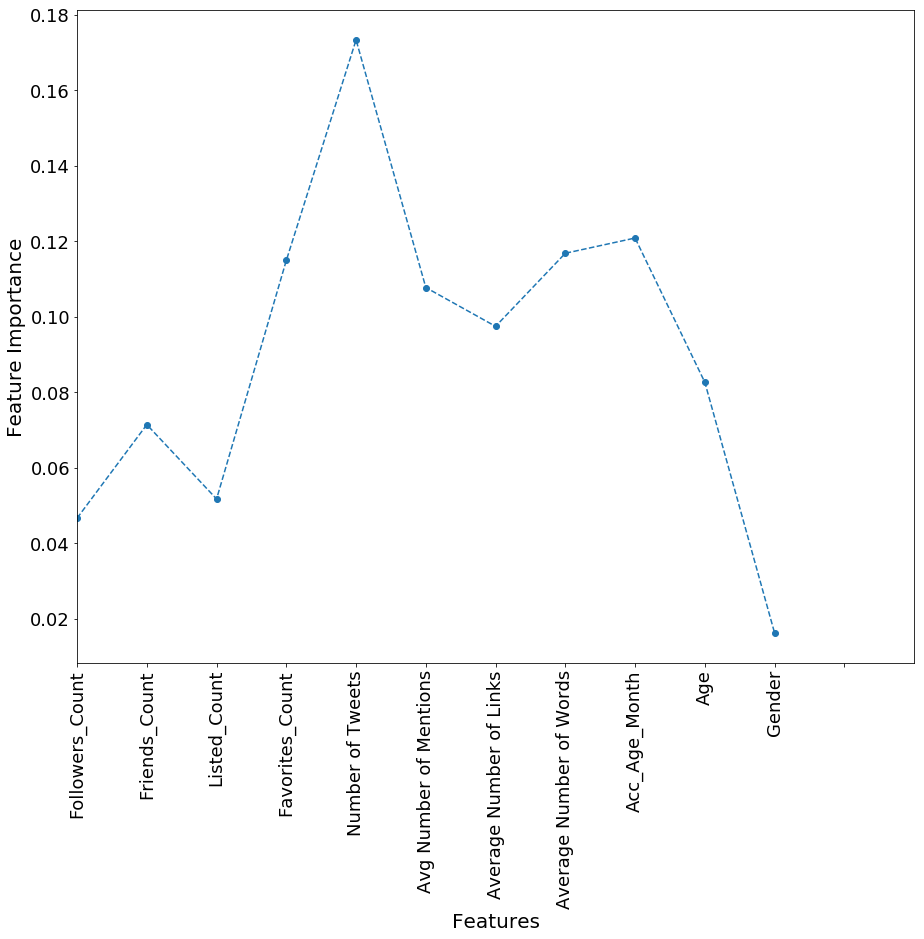

In [169]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [170]:
pd.Series(gbc.feature_importances_,index=columns)

Followers_Count            0.046663
Friends_Count              0.071436
Listed_Count               0.051737
Favorites_Count            0.114953
Number of Tweets           0.173363
Avg Number of Mentions     0.107758
Average Number of Links    0.097470
Average Number of Words    0.116837
Acc_Age_Month              0.120875
Age                        0.082658
Gender                     0.016249
dtype: float64

##### 2.3.6 Extra Tree CLassifier

In [171]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,20,auto,0.001,3,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8015768725361366

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1345   179     1524
True         425  1095     1520
__all__     1770  1274     3044

Accuracy of the  Extra Decision Tree  model for test data is: 0.7637795275590551

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        322    57      379
True         123   260      383
__all__      445   317      762

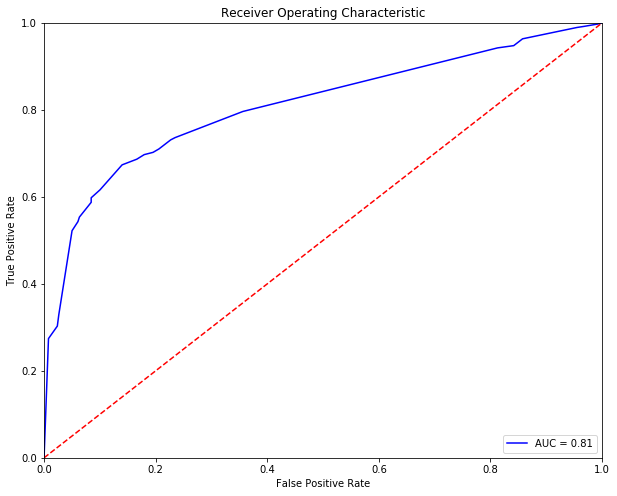

Optimal Threshold is 0.3142857142857143
Accuracy on test data is: 0.7519685039370079


Predicted  False  True  __all__
Actual                         
False        293    86      379
True         103   280      383
__all__      396   366      762

In [172]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [173]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

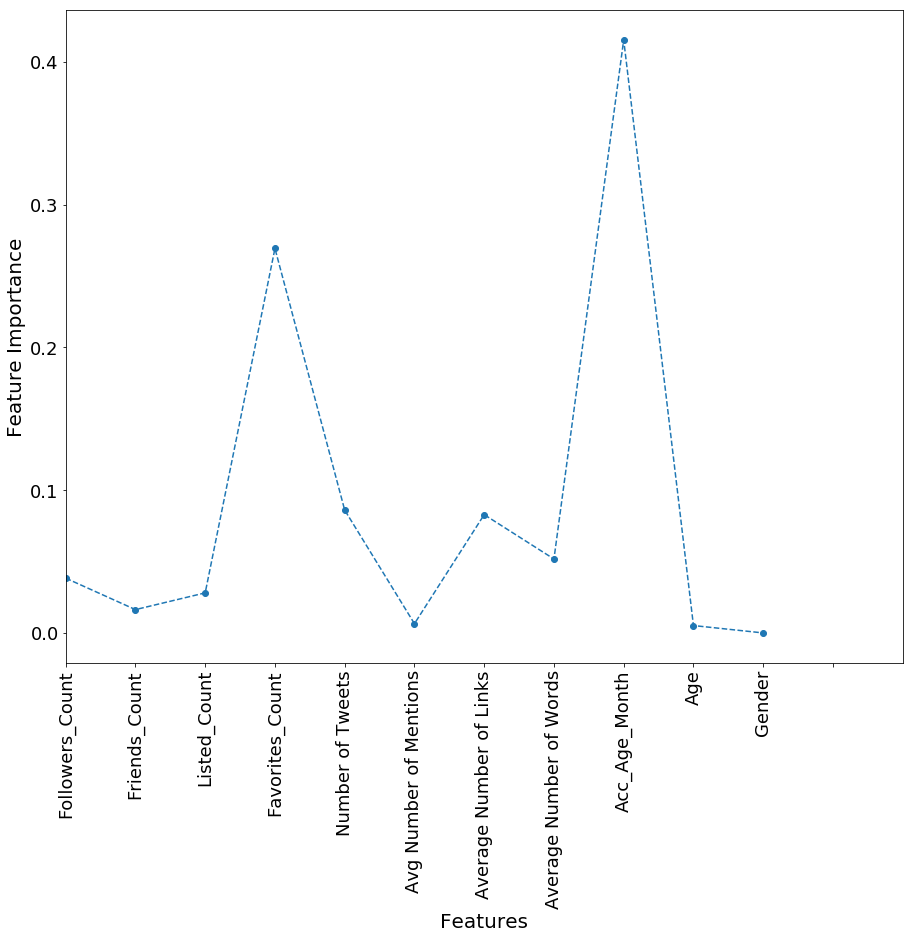

In [174]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [175]:
pd.Series(ext.feature_importances_,index=columns)

Followers_Count            0.038378
Friends_Count              0.016336
Listed_Count               0.028066
Favorites_Count            0.269366
Number of Tweets           0.086066
Avg Number of Mentions     0.006470
Average Number of Links    0.082883
Average Number of Words    0.051786
Acc_Age_Month              0.415480
Age                        0.005168
Gender                     0.000000
dtype: float64

##### 2.3.7 Bagging Classifier

In [176]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.4,300,True,0


Accuracy of the  Bagging  model for the training data is: 0.9878449408672799

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1515     9     1524
True          28  1492     1520
__all__     1543  1501     3044

Accuracy of the  Bagging  model for test data is: 0.7847769028871391

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        316    63      379
True         101   282      383
__all__      417   345      762

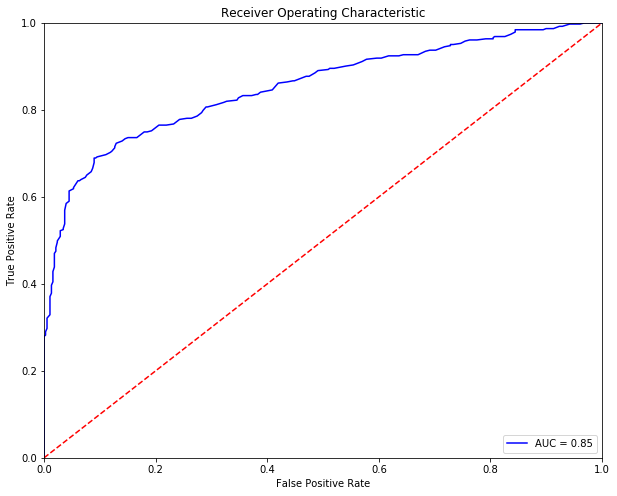

Optimal Threshold is 0.47
Accuracy on test data is: 0.7729658792650919


Predicted  False  True  __all__
Actual                         
False        296    83      379
True          90   293      383
__all__      386   376      762

In [177]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [178]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.8 Voting Classifier

In [179]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9684625492772667


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       1500    24     1524
True          72  1448     1520
__all__     1572  1472     3044

The test accuracy is: 0.7887139107611548


Predicted  False  True  __all__
Actual                         
False        313    66      379
True          95   288      383
__all__      408   354      762

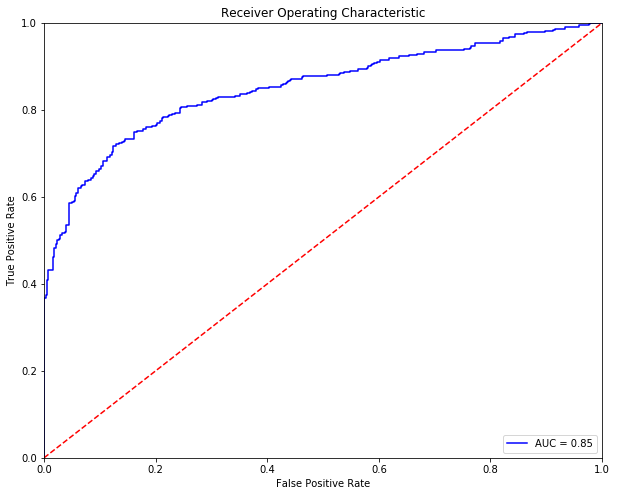

Optimal Threshold is 0.47278114679259614
Accuracy on test data is: 0.7834645669291339


Predicted  False  True  __all__
Actual                         
False        298    81      379
True          84   299      383
__all__      382   380      762

In [180]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [181]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.9 Deep Learning

In [182]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8416557161629435


Predicted  False  True  __all__
Actual                         
False       1372   152     1524
True         330  1190     1520
__all__     1702  1342     3044

The accuracy of the model on test data is: 0.7506561679790026


Predicted  False  True  __all__
Actual                         
False        306    73      379
True         117   266      383
__all__      423   339      762

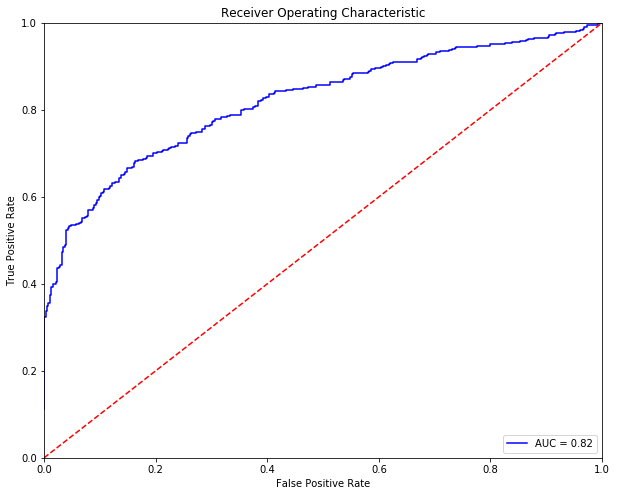

Optimal Threshold is 0.41810343
Accuracy of Logistic Model on training data is: 0.7401574803149606


Predicted  False  True  __all__
Actual                         
False        281    98      379
True         100   283      383
__all__      381   381      762

In [183]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [184]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.10 Deep Learning with Grid Search

In [185]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.5min finished


The accuracy of the model on training data is: 0.7582128777923784


Predicted  False  True  __all__
Actual                         
False       1339   185     1524
True         551   969     1520
__all__     1890  1154     3044

The accuracy of the model on test data is: 0.7650918635170604


Predicted  False  True  __all__
Actual                         
False        339    40      379
True         139   244      383
__all__      478   284      762

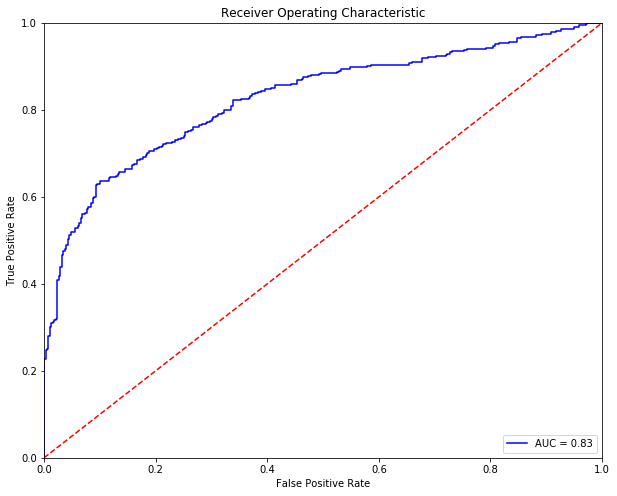

Optimal Threshold is 0.32520536
Accuracy on test data is: 0.7467191601049868


Predicted  False  True  __all__
Actual                         
False        283    96      379
True          97   286      383
__all__      380   382      762

In [186]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [187]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

###   <a id='2.3.1' style="text-decoration : none; color: #000000;"> 2.3.1  Results </a>

In [188]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1520.0,1524.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.724704,1036.0,1170.0,354.0,484.0,0.232283,0.318421
RandomForestClassifier,0.643561,436.0,1523.0,1.0,1084.0,0.000656,0.713158
AdaBoostClassifier,0.791393,1126.0,1283.0,241.0,394.0,0.158136,0.259211
GradientBoostingClassifier,0.829172,1166.0,1358.0,166.0,354.0,0.108924,0.232895
ExtraTreeClassifier,0.801577,1095.0,1345.0,179.0,425.0,0.117454,0.279605
BaggingClassifier,0.987845,1492.0,1515.0,9.0,28.0,0.005906,0.018421
VotingClassifier,0.968463,1448.0,1500.0,24.0,72.0,0.015748,0.047368
Neural Network-1,0.841656,1190.0,1372.0,152.0,330.0,0.099738,0.217105


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.745407,251.0,317.0,62.0,132.0,0.163588,0.344648
LogisticRegression,0.729659,264.0,292.0,87.0,119.0,0.229551,0.310705
RandomForestClassifier,0.653543,119.0,379.0,0.0,264.0,0.000000,0.689295
AdaBoostClassifier,0.767717,283.0,302.0,77.0,100.0,0.203166,0.261097
GradientBoostingClassifier,0.805774,280.0,334.0,45.0,103.0,0.118734,0.268930
ExtraTreeClassifier,0.763780,260.0,322.0,57.0,123.0,0.150396,0.321149
BaggingClassifier,0.784777,282.0,316.0,63.0,101.0,0.166227,0.263708
VotingClassifier,0.788714,288.0,313.0,66.0,95.0,0.174142,0.248042
Neural Network-1,0.750656,266.0,306.0,73.0,117.0,0.192612,0.305483


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.753281,288.000000,286.000000,93.000000,95.000000,0.245383,0.248042,0.409139,0.828517
LogisticRegression,0.723097,277.000000,274.000000,105.000000,106.000000,0.277045,0.276762,0.483200,0.792142
RandomForestClassifier,0.497375,188.505249,190.494751,190.494751,192.505249,0.497375,0.502625,0.629392,0.655352
AdaBoostClassifier,0.750656,288.000000,284.000000,95.000000,95.000000,0.250660,0.248042,0.501757,0.822964
GradientBoostingClassifier,0.784777,299.000000,299.000000,80.000000,84.000000,0.211082,0.219321,0.405480,0.848626
ExtraTreeClassifier,0.751969,280.000000,293.000000,86.000000,103.000000,0.226913,0.268930,0.314286,0.809837
BaggingClassifier,0.772966,293.000000,296.000000,83.000000,90.000000,0.218997,0.234987,0.470000,0.852701
VotingClassifier,0.783465,299.000000,298.000000,81.000000,84.000000,0.213720,0.219321,0.472781,0.850693
Neural Network-1,0.740157,283.000000,281.000000,98.000000,100.000000,0.258575,0.261097,0.418103,0.819864


In [189]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')